In [1]:
# -*- coding: utf-8 -*-
### RUN IN PYTHON 3
import os
import cv2
import csv
import glob
import click
import logging
import numpy as np
import pandas as pd

from PIL import Image 
from tqdm import tqdm
from dotenv import find_dotenv, load_dotenv
from sklearn import preprocessing
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R
from scipy.ndimage.interpolation import map_coordinates

data_dir = '/home/user/Robotics/Data_sets/slip_detection/will_dataset/will_data_collection/data_collection_001/'
out_dir = '/home/user/Robotics/Data_sets/slip_detection/manual_slip_detection/'
SAVE_IMAGES= True
sequence_length = 20 # 20 for 10 step prediction or even 58 frames
image_height, image_width = 32, 32
save_deriv1 = True
save_deriv2 = True

In [2]:
## Load the data:
files = glob.glob(data_dir + '/*')
path_file = []
index_to_save = 0

xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final = [], [], []
xela_sensor1_data_x_final_1stderiv = []
xela_sensor1_data_y_final_1stderiv = []
xela_sensor1_data_z_final_1stderiv = []
xela_sensor1_data_x_final_2stderiv = []
xela_sensor1_data_y_final_2stderiv = []
xela_sensor1_data_z_final_2stderiv = []

ee_positions_final = []
ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []

exp_break_points = []
exp_break_point = 0
cut = 0

to_test_list = [data_dir + "data_sample_2021-03-26-09-45-38",
                data_dir + "data_sample_2021-06-12-11-43-06",
                data_dir + "data_sample_2021-06-12-11-21-33",
                data_dir + "data_sample_2021-06-11-18-53-59",
                data_dir + "data_sample_2021-06-11-17-48-49",
                data_dir + "data_sample_2021-06-11-17-43-52",
                data_dir + "data_sample_2021-06-11-19-00-56"]
index_to_test = []
reduce_length = 0
for experiment_number in tqdm(range(len(files))):
    meta_data = np.asarray(pd.read_csv(files[experiment_number] + '/meta_data.csv', header=None))
    robot_state  = np.asarray(pd.read_csv(files[experiment_number] + '/robot_state.csv', header=None))
    proximity    = np.asarray(pd.read_csv(files[experiment_number] + '/proximity.csv', header=None))
    xela_sensor1 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor1.csv', header=None))
    xela_sensor2 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor2.csv', header=None))

    if files[experiment_number] in to_test_list:
        index_to_test.append([experiment_number, files[experiment_number]])

    ee_positions = []
    ee_position_x, ee_position_y, ee_position_z = [], [], []
    ee_orientation_x, ee_orientation_y, ee_orientation_z = [], [], []
    ee_orientation_quat_x, ee_orientation_quat_y, ee_orientation_quat_z, ee_orientation_quat_w = [], [], [], []

    xela_sensor1_data_x, xela_sensor1_data_y, xela_sensor1_data_z = [], [], []
    xela_sensor2_data_x, xela_sensor2_data_y, xela_sensor2_data_z = [], [], []
    xela_sensor1_data_x_mean, xela_sensor1_data_y_mean, xela_sensor1_data_z_mean = [], [], []
    xela_sensor2_data_x_mean, xela_sensor2_data_y_mean, xela_sensor2_data_z_mean = [], [], []

    ####################################### Robot Data ###########################################
    for state in robot_state[1:]:
        ee_positions.append([float(item) for item in robot_state[1][-7:-4]])
        ee_position_x.append(state[-7])
        ee_position_y.append(state[-6])
        ee_position_z.append(state[-5])
        # quat
        ee_orientation_quat_x.append(state[-4])
        ee_orientation_quat_y.append(state[-3])
        ee_orientation_quat_z.append(state[-2])
        ee_orientation_quat_w.append(state[-1])
        # euler
        ee_orientation = R.from_quat([state[-4], state[-3], state[-2], state[-1]]).as_euler('zyx', degrees=True)
        ee_orientation_x.append(ee_orientation[0])
        ee_orientation_y.append(ee_orientation[1])
        ee_orientation_z.append(ee_orientation[2])
        exp_break_point += 1

    # fix the euler angles:
    for i in range(len(ee_orientation_z)):
        if ee_orientation_z[i] < 0:
            ee_orientation_z[i] += 360

    ####################################### Xela Data ###########################################
    for sample1, sample2 in zip(xela_sensor1[1:], xela_sensor2[1:]):
        sample1_data_x, sample1_data_y, sample1_data_z = [], [], []
        sample2_data_x, sample2_data_y, sample2_data_z = [], [], []
        for i in range(0, len(xela_sensor1[0]), 3):
            sample1_data_x.append(float(sample1[i]))
            sample1_data_y.append(float(sample1[i+1]))
            sample1_data_z.append(float(sample1[i+2]))
        xela_sensor1_data_x.append(sample1_data_x)
        xela_sensor1_data_y.append(sample1_data_y)
        xela_sensor1_data_z.append(sample1_data_z)

    # mean starting values:
    xela_sensor1_average_starting_value_x = int(sum(xela_sensor1_data_x[0]) / len(xela_sensor1_data_x[0]))
    xela_sensor1_average_starting_value_y = int(sum(xela_sensor1_data_y[0]) / len(xela_sensor1_data_y[0]))
    xela_sensor1_average_starting_value_z = int(sum(xela_sensor1_data_z[0]) / len(xela_sensor1_data_z[0]))
    xela_sensor1_offset_x = [xela_sensor1_average_starting_value_x - tactile_starting_value for tactile_starting_value in xela_sensor1_data_x[0]]
    xela_sensor1_offset_y = [xela_sensor1_average_starting_value_y - tactile_starting_value for tactile_starting_value in xela_sensor1_data_y[0]]
    xela_sensor1_offset_z = [xela_sensor1_average_starting_value_z - tactile_starting_value for tactile_starting_value in xela_sensor1_data_z[0]]

    for time_step in range(len(xela_sensor1_data_x)):
        xela_sensor1_sample_x_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_x, xela_sensor1_data_x[time_step])]
        xela_sensor1_sample_y_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_y, xela_sensor1_data_y[time_step])]
        xela_sensor1_sample_z_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_z, xela_sensor1_data_z[time_step])]
        for i in range(np.asarray(xela_sensor1_data_x).shape[1]):
            xela_sensor1_data_x[time_step][i] = xela_sensor1_sample_x_test[i]
            xela_sensor1_data_y[time_step][i] = xela_sensor1_sample_y_test[i] 
            xela_sensor1_data_z[time_step][i] = xela_sensor1_sample_z_test[i]

    # calculate the derivatives
    if save_deriv1 == True:
        cut = 1
        xela_deriv1_x = np.diff(np.array(xela_sensor1_data_x), axis=0).tolist()
        xela_deriv1_y = np.diff(np.array(xela_sensor1_data_y), axis=0).tolist()
        xela_deriv1_z = np.diff(np.array(xela_sensor1_data_z), axis=0).tolist()
        # store the data:
        xela_sensor1_data_x_final_1stderiv += xela_deriv1_x 
        xela_sensor1_data_y_final_1stderiv += xela_deriv1_y 
        xela_sensor1_data_z_final_1stderiv += xela_deriv1_z 

    if save_deriv2 == True:
        cut = 2
        xela1_deriv2_x = np.diff(np.array(xela_sensor1_data_x), axis=0, n=2).tolist()
        xela1_deriv2_y = np.diff(np.array(xela_sensor1_data_y), axis=0, n=2).tolist()
        xela1_deriv2_z = np.diff(np.array(xela_sensor1_data_z), axis=0, n=2).tolist()
        # store the data:
        xela_sensor1_data_x_final_2stderiv += xela1_deriv2_x 
        xela_sensor1_data_y_final_2stderiv += xela1_deriv2_y 
        xela_sensor1_data_z_final_2stderiv += xela1_deriv2_z        

    xela_sensor1_data_x_final += xela_sensor1_data_x[cut:]
    xela_sensor1_data_y_final += xela_sensor1_data_y[cut:]
    xela_sensor1_data_z_final += xela_sensor1_data_z[cut:]
    ee_positions_final += ee_positions[cut:]
    ee_position_x_final += ee_position_x[cut:]
    ee_position_y_final += ee_position_y[cut:]
    ee_position_z_final += ee_position_z[cut:]
    ee_orientation_quat_x_final += ee_orientation_quat_x[cut:]
    ee_orientation_quat_y_final += ee_orientation_quat_y[cut:]
    ee_orientation_quat_z_final += ee_orientation_quat_z[cut:]
    ee_orientation_quat_w_final += ee_orientation_quat_w[cut:]
    ee_orientation_x_final += ee_orientation_x[cut:]
    ee_orientation_y_final += ee_orientation_y[cut:]
    ee_orientation_z_final += ee_orientation_z[cut:]

    exp_break_points.append(exp_break_point - cut)

100%|██████████| 299/299 [02:31<00:00,  1.98it/s]


In [3]:
xela_sensor1_data_x_final = np.asarray(xela_sensor1_data_x_final)
xela_sensor1_data_y_final = np.asarray(xela_sensor1_data_y_final)
xela_sensor1_data_z_final = np.asarray(xela_sensor1_data_z_final)

scale_together = False
if scale_together == True:
    xela_sensor1_data = np.concatenate((xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final), axis=1)
    scaler_full = preprocessing.StandardScaler().fit(xela_sensor1_data)
    xela_sensor1_data_scaled = scaler_full.transform(xela_sensor1_data)
    min_max_scaler_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xela_sensor1_data_scaled)
    xela_sensor1_data_scaled_minmax = min_max_scaler_full_data.transform(xela_sensor1_data_scaled)

elif scale_together == False:
    scaler_tx = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final)
    scaler_ty = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final)
    scaler_tz = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final)
    xelax_sensor1_data_scaled = scaler_tx.transform(xela_sensor1_data_x_final)
    xelay_sensor1_data_scaled = scaler_ty.transform(xela_sensor1_data_y_final)
    xelaz_sensor1_data_scaled = scaler_tz.transform(xela_sensor1_data_z_final)
    xela_sensor1_data_scaled = np.concatenate((xelax_sensor1_data_scaled,
                                               xelay_sensor1_data_scaled,
                                               xelaz_sensor1_data_scaled), axis=1)
    
    min_max_scalerx_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1_data_scaled)
    min_max_scalery_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1_data_scaled)
    min_max_scalerz_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1_data_scaled)    
    xelax_sensor1_data_scaled_minmax = min_max_scalerx_full_data.transform(xelax_sensor1_data_scaled)
    xelay_sensor1_data_scaled_minmax = min_max_scalery_full_data.transform(xelay_sensor1_data_scaled)
    xelaz_sensor1_data_scaled_minmax = min_max_scalerz_full_data.transform(xelaz_sensor1_data_scaled)

    xela_sensor1_data_scaled_minmax = np.concatenate((xelax_sensor1_data_scaled_minmax,
                                        xelay_sensor1_data_scaled_minmax,
                                        xelaz_sensor1_data_scaled_minmax), axis=1)
    
if save_deriv1 == True:
    scaler_td1x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final_1stderiv)
    scaler_td1y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final_1stderiv)
    scaler_td1z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final_1stderiv)
    xelax_sensor1d1_data_scaled = scaler_td1x.transform(xela_sensor1_data_x_final_1stderiv)
    xelay_sensor1d1_data_scaled = scaler_td1y.transform(xela_sensor1_data_y_final_1stderiv)
    xelaz_sensor1d1_data_scaled = scaler_td1z.transform(xela_sensor1_data_z_final_1stderiv)
    xelad1_sensor1_data_scaled = np.concatenate((xelax_sensor1d1_data_scaled,
                                               xelay_sensor1d1_data_scaled,
                                               xelaz_sensor1d1_data_scaled), axis=1)
    
    min_max_scalerd1x_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1d1_data_scaled)
    min_max_scalerd1y_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1d1_data_scaled)
    min_max_scalerd1z_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1d1_data_scaled)    
    xelad1x_sensor1_data_scaled_minmax = min_max_scalerd1x_full_data.transform(xelax_sensor1d1_data_scaled)
    xelad1y_sensor1_data_scaled_minmax = min_max_scalerd1y_full_data.transform(xelay_sensor1d1_data_scaled)
    xelad1z_sensor1_data_scaled_minmax = min_max_scalerd1z_full_data.transform(xelaz_sensor1d1_data_scaled)

    xelad1_sensor1_data_scaled_minmax = np.concatenate((xelad1x_sensor1_data_scaled_minmax,
                                        xelad1y_sensor1_data_scaled_minmax,
                                        xelad1z_sensor1_data_scaled_minmax), axis=1)

if save_deriv2 == True:
    scaler_td2x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final_2stderiv)
    scaler_td2y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final_2stderiv)
    scaler_td2z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final_2stderiv)
    xelax_sensor1d2_data_scaled = scaler_td2x.transform(xela_sensor1_data_x_final_2stderiv)
    xelay_sensor1d2_data_scaled = scaler_td2y.transform(xela_sensor1_data_y_final_2stderiv)
    xelaz_sensor1d2_data_scaled = scaler_td2z.transform(xela_sensor1_data_z_final_2stderiv)
    xelad2_sensor1_data_scaled = np.concatenate((xelax_sensor1d2_data_scaled,
                                               xelay_sensor1d2_data_scaled,
                                               xelaz_sensor1d2_data_scaled), axis=1)
    
    min_max_scalerd2x_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1d2_data_scaled)
    min_max_scalerd2y_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1d2_data_scaled)
    min_max_scalerd2z_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1d2_data_scaled)    
    xelad2x_sensor1_data_scaled_minmax = min_max_scalerd2x_full_data.transform(xelax_sensor1d2_data_scaled)
    xelad2y_sensor1_data_scaled_minmax = min_max_scalerd2y_full_data.transform(xelay_sensor1d2_data_scaled)
    xelad2z_sensor1_data_scaled_minmax = min_max_scalerd2z_full_data.transform(xelaz_sensor1d2_data_scaled)

    xelad2_sensor1_data_scaled_minmax = np.concatenate((xelad2x_sensor1_data_scaled_minmax,
                                        xelad2y_sensor1_data_scaled_minmax,
                                        xelad2z_sensor1_data_scaled_minmax), axis=1)

In [4]:
# -*- coding: utf-8 -*-
import csv
import tqdm
import copy
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 100
batch_size = 32
learning_rate = 1e-3
context_frames = 10
# sequence_length = 10 # 20 for 10 step prediction
lookback = sequence_length

valid_train_split = 0.85  # precentage of train data from total
test_train_split = 0.92  # precentage of train data from total

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available
################################# CHANGE THIS!!!!  #################################
model_path = "/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/CorlPaperFinal/model_t1/"
################################# CHANGE THIS!!!!  #################################

In [5]:
for i in index_to_test:
    print(i)

[16, '/home/user/Robotics/Data_sets/slip_detection/will_dataset/will_data_collection/data_collection_001/data_sample_2021-06-11-18-53-59']
[46, '/home/user/Robotics/Data_sets/slip_detection/will_dataset/will_data_collection/data_collection_001/data_sample_2021-06-11-17-48-49']
[84, '/home/user/Robotics/Data_sets/slip_detection/will_dataset/will_data_collection/data_collection_001/data_sample_2021-06-11-17-43-52']
[150, '/home/user/Robotics/Data_sets/slip_detection/will_dataset/will_data_collection/data_collection_001/data_sample_2021-03-26-09-45-38']
[195, '/home/user/Robotics/Data_sets/slip_detection/will_dataset/will_data_collection/data_collection_001/data_sample_2021-06-11-19-00-56']
[199, '/home/user/Robotics/Data_sets/slip_detection/will_dataset/will_data_collection/data_collection_001/data_sample_2021-06-12-11-43-06']
[257, '/home/user/Robotics/Data_sets/slip_detection/will_dataset/will_data_collection/data_collection_001/data_sample_2021-06-12-11-21-33']


In [6]:
# scale between 0 and 1:
ee_position_x_final = np.array(ee_position_x_final) 
ee_position_y_final = np.array(ee_position_y_final) 
ee_position_z_final = np.array(ee_position_z_final) 
ee_orientation_quat_x_final = np.array(ee_orientation_quat_x_final).reshape(-1, 1)
ee_orientation_quat_y_final = np.array(ee_orientation_quat_y_final).reshape(-1, 1)
ee_orientation_quat_z_final = np.array(ee_orientation_quat_z_final).reshape(-1, 1)
ee_orientation_quat_w_final = np.array(ee_orientation_quat_w_final).reshape(-1, 1)
ee_orientation_x_final = np.array(ee_orientation_x_final)
ee_orientation_y_final = np.array(ee_orientation_y_final)
ee_orientation_z_final = np.array(ee_orientation_z_final)
# xela_sensor1_principle_components = np.array(xela_sensor1_principle_components) 
xela_sensor1_principle_components =  np.array(xela_sensor1_data_scaled)
if save_deriv1 == True:
    xelad1_sensor1_data_scaled_minmax = np.array(xelad1_sensor1_data_scaled_minmax)
if save_deriv2 == True:
    xelad2_sensor1_data_scaled_minmax = np.array(xelad2_sensor1_data_scaled_minmax)

min_max_scaler_ee_position_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_x_final.reshape(-1, 1))
ee_position_x_final_scaled = min_max_scaler_ee_position_x_final.transform(ee_position_x_final.reshape(-1, 1))

min_max_scaler_ee_position_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_y_final.reshape(-1, 1))
ee_position_y_final_scaled = min_max_scaler_ee_position_y_final.transform(ee_position_y_final.reshape(-1, 1))

min_max_scaler_ee_position_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_z_final.reshape(-1, 1))
ee_position_z_final_scaled = min_max_scaler_ee_position_z_final.transform(ee_position_z_final.reshape(-1, 1))

min_max_scaler_ee_orientation_quat_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_x_final)
ee_orientation_quat_x_final_scaled = min_max_scaler_ee_orientation_quat_x_final.transform(ee_orientation_quat_x_final)

min_max_scaler_ee_orientation_quat_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_y_final)
ee_orientation_quat_y_final_scaled = min_max_scaler_ee_orientation_quat_y_final.transform(ee_orientation_quat_y_final)

min_max_scaler_ee_orientation_quat_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_z_final)
ee_orientation_quat_z_final_scaled = min_max_scaler_ee_orientation_quat_z_final.transform(ee_orientation_quat_z_final)

min_max_scaler_ee_orientation_quat_w_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_w_final)
ee_orientation_quat_w_final_scaled = min_max_scaler_ee_orientation_quat_w_final.transform(ee_orientation_quat_w_final)

min_max_scaler_ee_orientation_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_x_final.reshape(-1, 1))
ee_orientation_x_final_scaled = min_max_scaler_ee_orientation_x_final.transform(ee_orientation_x_final.reshape(-1, 1))

min_max_scaler_ee_orientation_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_y_final.reshape(-1, 1))
ee_orientation_y_final_scaled = min_max_scaler_ee_orientation_y_final.transform(ee_orientation_y_final.reshape(-1, 1))

min_max_scaler_ee_orientation_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_z_final.reshape(-1, 1))
ee_orientation_z_final_scaled = min_max_scaler_ee_orientation_z_final.transform(ee_orientation_z_final.reshape(-1, 1))

if scale_together == True:
    min_max_scaler_xela_sensor1_principle_components = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xela_sensor1_principle_components)
    xela_sensor1_principle_components_scaled = min_max_scaler_xela_sensor1_principle_components.transform(xela_sensor1_principle_components)
else:
    xela_sensor1_principle_components_scaled = xela_sensor1_data_scaled_minmax

if save_deriv1 == True:
    xelad1_sensor1_principle_components_scaled = xelad1_sensor1_data_scaled_minmax
if save_deriv2 == True:
    xelad2_sensor1_principle_components_scaled = xelad2_sensor1_data_scaled_minmax

# Convert data back into split experiments to create the sequences:
ee_position_x_final_split = np.asarray(np.split(ee_position_x_final_scaled, exp_break_points)[0:-1])
ee_position_y_final_split = np.asarray(np.split(ee_position_y_final_scaled, exp_break_points)[0:-1])
ee_position_z_final_split = np.asarray(np.split(ee_position_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_x_final_split = np.asarray(np.split(ee_orientation_quat_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_y_final_split = np.asarray(np.split(ee_orientation_quat_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_z_final_split = np.asarray(np.split(ee_orientation_quat_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_w_final_split = np.asarray(np.split(ee_orientation_quat_w_final_scaled, exp_break_points)[0:-1])
ee_orientation_x_final_split = np.asarray(np.split(ee_orientation_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_y_final_split = np.asarray(np.split(ee_orientation_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_z_final_split = np.asarray(np.split(ee_orientation_z_final_scaled, exp_break_points)[0:-1])
xela_sensor1_principle_components_split = np.asarray(np.split(xela_sensor1_principle_components_scaled, exp_break_points)[0:-1])
if save_deriv1 == True:
    xela_sensor1_data_1stderiv_scaled_split = np.asarray(np.split(xelad1_sensor1_principle_components_scaled, exp_break_points)[0:-1])
if save_deriv2 == True:
    xela_sensor1_data_2stderiv_scaled_split = np.asarray(np.split(xelad2_sensor1_principle_components_scaled, exp_break_points)[0:-1])

# Shuffle data:
p = np.load("/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/CorlPaperFinal/shuffle_order.npy")
print("shuffle order: ", p)
ee_position_x_final_split = ee_position_x_final_split[p]
ee_position_y_final_split = ee_position_y_final_split[p]
ee_position_z_final_split = ee_position_z_final_split[p]
ee_orientation_quat_x_final_split = ee_orientation_quat_x_final_split[p]
ee_orientation_quat_y_final_split = ee_orientation_quat_y_final_split[p]
ee_orientation_quat_z_final_split = ee_orientation_quat_z_final_split[p]
ee_orientation_quat_w_final_split = ee_orientation_quat_w_final_split[p]
ee_orientation_x_final_split = ee_orientation_x_final_split[p]
ee_orientation_y_final_split = ee_orientation_y_final_split[p]
ee_orientation_z_final_split = ee_orientation_z_final_split[p]
xela_sensor1_principle_components_split = xela_sensor1_principle_components_split[p]
if save_deriv1 == True:
    xela_sensor1_data_1stderiv_scaled_split = xela_sensor1_data_1stderiv_scaled_split[p]
if save_deriv2 == True:
    xela_sensor1_data_2stderiv_scaled_split = xela_sensor1_data_2stderiv_scaled_split[p]

ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []
xela_sensor1_principle_components = []
ee_position_x_final_scaled = []
ee_position_y_final_scaled = []
ee_position_z_final_scaled = []
ee_orientation_quat_x_final_scaled = []
ee_orientation_quat_y_final_scaled = []
ee_orientation_quat_z_final_scaled = []
ee_orientation_quat_w_final_scaled = []
ee_orientation_x_final_scaled = []
ee_orientation_y_final_scaled = []
ee_orientation_z_final_scaled = []
xela_sensor1_data_x_final = []
xela_sensor1_data_y_final = []
xela_sensor1_data_z_final = []
ee_positions_final = []
ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []

xela_sensor1_data_x_final = []
xela_sensor1_data_y_final = []
xela_sensor1_data_z_final = []
xelax_sensor1_data_scaled_minmax = []
xelay_sensor1_data_scaled_minmax = []
xelaz_sensor1_data_scaled_minmax = []
xela_sensor1_data_scaled_minmax = []


# convert to sequences:
robot_data_euler_sequence, robot_data_quat_sequence, xela_1_sequence_data, experiment_data_sequence, time_step_data_sequence = [], [], [], [], []
xela1_1stderiv_sequence = []
xela1_2stderiv_sequence = []
for experiment in range(len(ee_position_x_final_split)):
    for sample in range(0, len(ee_position_x_final_split[experiment]) - sequence_length):
        robot_data_euler_sample, robot_data_quat_sample, xela_1_sequ_sample, experiment_data_sample, time_step_data_sample = [], [], [], [], []
        xela_sensor1_1stderiv = []
        xela_sensor1_2stderiv = []
        for t in range(0, sequence_length):
            robot_data_euler_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_x_final_split[experiment][sample+t], ee_orientation_y_final_split[experiment][sample+t], ee_orientation_z_final_split[experiment][sample+t]])
            robot_data_quat_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_quat_x_final_split[experiment][sample+t][0], ee_orientation_quat_y_final_split[experiment][sample+t][0], ee_orientation_quat_z_final_split[experiment][sample+t][0], ee_orientation_quat_w_final_split[experiment][sample+t][0]])
            xela_1_sequ_sample.append(xela_sensor1_principle_components_split[experiment][sample+t])
            if save_deriv1 == True:
                xela_sensor1_1stderiv.append(xela_sensor1_data_1stderiv_scaled_split[experiment][sample+t])
            if save_deriv2 == True:
                xela_sensor1_2stderiv.append(xela_sensor1_data_2stderiv_scaled_split[experiment][sample+t])
            experiment_data_sample.append(experiment)
            time_step_data_sample.append(sample+t)
        robot_data_euler_sequence.append(robot_data_euler_sample)
        robot_data_quat_sequence.append(robot_data_quat_sample)
        xela_1_sequence_data.append(xela_1_sequ_sample)
        xela1_1stderiv_sequence.append(xela_sensor1_1stderiv)
        xela1_2stderiv_sequence.append(xela_sensor1_2stderiv)
        experiment_data_sequence.append(experiment_data_sample)
        time_step_data_sequence.append(time_step_data_sample)

shuffle order:  [204 160 153 234  91 137 176 243 274 238  13 175  30 127 197 102 205 151
 107  50 298  48  64 245 158 130 154 254  29 201  20 249 131 272 120 208
   3   5  90 212   0 209 206 145 198 143  54 118 172  59 213 210 267 188
 146  96  81 155 273 296 203 280 169 193 186 225  45 144  75  21  51 138
 141 117 294 236 229  37  61 112 284 231 194 261 214  80  39 171  53 180
 165  35  42 129 166  99 140  77 290  11  31 187 242 297  78 170 230 292
 207 215  76 163  10 253 181  56 122  83  86   8 148  72  70 126 285  26
 113 288 115  19 162 239  23 142  57 256 293   4  28 269 136 108 262 279
 228  60 240  71 149  89  40 232  44 103   2 133  65  85   7  41 123 211
  73  94 134  67 286 227  25 110 190 246  34  12 219 237 191 184  32 114
 222  33 250  36 174 266 264 202 271 182 189  24 109 157  87 247 105  17
   6 241  58 159 235 119 100 101 224 268 216 223 259 104 226  62 200  79
 295 220  43 255 282 196  55  93 289 185 192 263 178 217 139  69   9 111
 132 121 167 278 265 221 183 276 12

In [7]:
class BatchGenerator:
    def __init__(self):
        pass

    def load_full_data(self):
        dataset_train = FullDataSet(type_="train")
        dataset_valid = FullDataSet(type_="valid")
        dataset_test = FullDataSet(type_="test")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader

class FullDataSet():
    def __init__(self, type_="train"):
        if type_ == "train":
            self.samples = [0, int(len(robot_data_euler_sequence)*test_train_split)]
        elif type_ == "valid":
            self.samples = [int(len(robot_data_euler_sequence)*(valid_train_split)), int(len(robot_data_euler_sequence)*test_train_split)]
        elif type_ == "test":
            self.samples = [int(len(robot_data_euler_sequence)*test_train_split), len(robot_data_euler_sequence)]

    def __len__(self):
        return self.samples[1] - self.samples[0]

    def __getitem__(self,idx):
        robot_euler = robot_data_euler_sequence[self.samples[0] + idx]
        xela1 = xela_1_sequence_data[self.samples[0] + idx]
        experiment = experiment_data_sequence[self.samples[0] + idx]
        time_step  = time_step_data_sequence[self.samples[0] + idx]
        xela1_d1 = xela1_1stderiv_sequence[self.samples[0] + idx]
        xela1_d2 = xela1_2stderiv_sequence[self.samples[0] + idx]
        return([np.array(robot_euler).astype(np.float32),
                np.array(xela1).astype(np.float32),
                np.array(xela1_d1).astype(np.float32),
                np.array(xela1_d2).astype(np.float32),
                np.array(experiment),
                np.array(time_step)])

In [39]:
# single LSTM attempt
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(48 + 48, 200).to(device)  # tactile
        self.lstm2 = nn.LSTM(200, 200).to(device)  # tactile
        self.fc1 = nn.Linear(200 + 48, 200).to(device)  # tactile + pos_vel
        self.fc2 = nn.Linear(200, 48).to(device)  # tactile + pos_vel
        self.tan_activation = nn.Tanh().to(device)

    def forward(self, tactiles, actions, tac_deriv1, tac_deriv2):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.zeros(1,batch_size__,200, device=torch.device('cuda')), torch.zeros(1,batch_size__,200, device=torch.device('cuda')))
        hidden2 = (torch.zeros(1,batch_size__,200, device=torch.device('cuda')), torch.zeros(1,batch_size__,200, device=torch.device('cuda')))

        for index, (sample_tactile, sample_action, sample_tactilederiv1, sample_tactilederiv2) in enumerate(zip(tactiles.squeeze()[:-1], actions.squeeze()[1:], tac_deriv1.squeeze()[:-1], tac_deriv2.squeeze()[:-1])):
            # 2. Run through lstm:
            if index > context_frames-1:
                out4 = out4 .squeeze()
                tiled_action_and_state = torch.cat((actions.squeeze()[index+1], state, actions.squeeze()[index+1], state,
                                                   actions.squeeze()[index+1], state, actions.squeeze()[index+1], state), 1)                
                action_and_tactile = torch.cat((out4, tiled_action_and_state), 1)
                out1, hidden1 = self.lstm1(action_and_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(out1, hidden2)
                lstm_and_prev_tactile = torch.cat((out2.squeeze(), out4), 1)
                out3 = self.tan_activation(self.fc1(lstm_and_prev_tactile))
                out4 = self.tan_activation(self.fc2(out3))
                outputs.append(out4.squeeze())
            else:
                tiled_action_and_state = torch.cat((actions.squeeze()[index+1], state, actions.squeeze()[index+1], state,
                                                   actions.squeeze()[index+1], state, actions.squeeze()[index+1], state), 1)                
                action_and_tactile = torch.cat((sample_tactile, tiled_action_and_state), 1)                
                out1, hidden1 = self.lstm1(action_and_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(out1, hidden2)
                lstm_and_prev_tactile = torch.cat((out2.squeeze(), sample_tactile), 1)
                out3 = self.tan_activation(self.fc1(lstm_and_prev_tactile))
                out4 = self.tan_activation(self.fc2(out3))
        outputs = [out4] + outputs
        return torch.stack(outputs)

In [40]:
class ModelTrainer:
    def __init__(self):
        self.train_full_loader, self.valid_full_loader, self.test_full_loader = BG.load_full_data()
        self.full_model = FullModel()
        self.criterion = nn.L1Loss()
        self.criterion1 = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)

    def train_full_model(self):
        plot_training_loss = []
        plot_validation_loss = []
        previous_val_mean_loss = 100.0
        best_val_loss = 100.0
        early_stop_clock = 0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_full_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0.0
            losses = 0.0
            for index, batch_features in enumerate(self.train_full_loader):
                action = batch_features[0].squeeze(-1).permute(1,0,2).to(device)
                tactile = batch_features[1].permute(1,0,2).to(device)
                tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
                tactilederiv2 = batch_features[3].permute(1,0,2).to(device)                
                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                loss = self.criterion(tactile_predictions, tactile[context_frames:])
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()
            plot_training_loss.append(mean)

            val_losses = 0.0
            val_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_full_loader):
                    action = batch_features[0].squeeze(-1).permute(1,0,2).to(device)
                    tactile = batch_features[1].permute(1,0,2).to(device)
                    tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
                    tactilederiv2 = batch_features[3].permute(1,0,2).to(device)
                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.                    
                    ground_truth = tactile[context_frames:]
                    self.optimizer.zero_grad()
                    val_loss = self.criterion(tactile_predictions[:,:,:48].to(device), ground_truth[:,:,:48])
                    val_losses += val_loss.item()

            print("Validation mean loss: {:.4f}, ".format(val_losses / index__))
            plot_validation_loss.append(val_losses / index__)
            if previous_val_mean_loss < val_losses / index__:
                early_stop_clock +=1
                previous_val_mean_loss = val_losses / index__ 
                if early_stop_clock == 3:
                    print("Early stopping")
                    break
            else:
                if best_val_loss > val_losses / index__:
                    print("saving model")
                    torch.save(self.full_model, model_path + "model_t1_corrected")
                    self.strongest_model = copy.deepcopy(self.full_model)
                    best_val_loss = val_losses / index__
                early_stop_clock = 0
                previous_val_mean_loss = val_losses / index__ 
            plt.plot(plot_training_loss, c="r", label="train loss MAE")
            plt.plot(plot_validation_loss, c='b', label="val loss MAE")
            plt.legend(loc="upper right")
            plt.savefig(model_path + '/trining_plot_10steppred_new_data.png', dpi=300)

epoch: 1, loss: 0.0145, mean loss: 0.0000, :   1%|          | 5620/562000 [02:47<4:22:18, 35.35it/s]

Validation mean loss: 0.0103, 
saving model


epoch: 2, loss: 0.0087, mean loss: 0.0000, :   2%|▏         | 11240/562000 [05:35<4:22:04, 35.02it/s]

Validation mean loss: 0.0087, 
saving model


epoch: 3, loss: 0.0111, mean loss: 0.0000, :   3%|▎         | 16860/562000 [08:23<4:26:24, 34.10it/s] 

Validation mean loss: 0.0087, 


epoch: 3, loss: 0.0089, mean loss: 0.0090, :   4%|▍         | 22484/562000 [11:09<62:22:22,  2.40it/s]

Validation mean loss: 0.0076, 
saving model


epoch: 4, loss: 0.0084, mean loss: 0.0085, :   5%|▌         | 28103/562000 [13:49<4:14:40, 34.94it/s] 

Validation mean loss: 0.0072, 
saving model


epoch: 5, loss: 0.0107, mean loss: 0.0082, :   6%|▌         | 33723/562000 [16:35<4:09:14, 35.33it/s] 

Validation mean loss: 0.0070, 
saving model


epoch: 6, loss: 0.0079, mean loss: 0.0079, :   7%|▋         | 39343/562000 [19:21<4:08:45, 35.02it/s] 

Validation mean loss: 0.0065, 
saving model


epoch: 7, loss: 0.0078, mean loss: 0.0076, :   8%|▊         | 44963/562000 [22:08<4:05:20, 35.12it/s] 

Validation mean loss: 0.0065, 
saving model


epoch: 8, loss: 0.0046, mean loss: 0.0075, :   9%|▉         | 50583/562000 [24:54<4:03:08, 35.06it/s] 

Validation mean loss: 0.0062, 
saving model


epoch: 9, loss: 0.0066, mean loss: 0.0074, :  10%|█         | 56203/562000 [27:45<4:12:34, 33.38it/s] 

Validation mean loss: 0.0062, 
saving model


epoch: 10, loss: 0.0065, mean loss: 0.0071, :  11%|█         | 61823/562000 [30:39<4:09:48, 33.37it/s] 

Validation mean loss: 0.0062, 


epoch: 11, loss: 0.0072, mean loss: 0.0071, :  12%|█▏        | 67443/562000 [33:33<4:08:30, 33.17it/s] 

Validation mean loss: 0.0060, 
saving model


epoch: 12, loss: 0.0073, mean loss: 0.0069, :  13%|█▎        | 73063/562000 [36:27<4:04:03, 33.39it/s] 

Validation mean loss: 0.0064, 


epoch: 13, loss: 0.0063, mean loss: 0.0068, :  14%|█▍        | 78683/562000 [39:21<4:01:25, 33.37it/s] 

Validation mean loss: 0.0058, 
saving model


epoch: 14, loss: 0.0048, mean loss: 0.0067, :  15%|█▌        | 84303/562000 [42:14<3:56:38, 33.64it/s] 

Validation mean loss: 0.0057, 
saving model


epoch: 15, loss: 0.0070, mean loss: 0.0066, :  16%|█▌        | 89923/562000 [45:08<3:54:51, 33.50it/s] 

Validation mean loss: 0.0073, 


epoch: 16, loss: 0.0077, mean loss: 0.0066, :  17%|█▋        | 95543/562000 [48:02<3:53:31, 33.29it/s] 

Validation mean loss: 0.0055, 
saving model


epoch: 17, loss: 0.0064, mean loss: 0.0066, :  18%|█▊        | 101163/562000 [50:56<3:50:32, 33.32it/s]

Validation mean loss: 0.0057, 


epoch: 18, loss: 0.0072, mean loss: 0.0064, :  19%|█▉        | 106783/562000 [53:50<3:47:20, 33.37it/s] 

Validation mean loss: 0.0058, 


epoch: 19, loss: 0.0069, mean loss: 0.0064, :  20%|██        | 112403/562000 [56:44<3:45:30, 33.23it/s] 

Validation mean loss: 0.0054, 
saving model


epoch: 20, loss: 0.0047, mean loss: 0.0064, :  21%|██        | 118023/562000 [59:38<3:42:25, 33.27it/s] 

Validation mean loss: 0.0052, 
saving model


epoch: 21, loss: 0.0087, mean loss: 0.0063, :  22%|██▏       | 123643/562000 [1:02:24<3:27:52, 35.15it/s]

Validation mean loss: 0.0053, 


epoch: 22, loss: 0.0057, mean loss: 0.0063, :  23%|██▎       | 129263/562000 [1:05:10<3:25:07, 35.16it/s] 

Validation mean loss: 0.0052, 
saving model


epoch: 23, loss: 0.0062, mean loss: 0.0061, :  24%|██▍       | 134883/562000 [1:07:55<3:22:58, 35.07it/s] 

Validation mean loss: 0.0052, 


epoch: 24, loss: 0.0044, mean loss: 0.0061, :  25%|██▌       | 140503/562000 [1:10:42<3:27:19, 33.88it/s] 

Validation mean loss: 0.0053, 


epoch: 25, loss: 0.0042, mean loss: 0.0061, :  26%|██▌       | 146123/562000 [1:13:35<3:24:03, 33.97it/s] 

Validation mean loss: 0.0050, 
saving model


epoch: 26, loss: 0.0053, mean loss: 0.0060, :  27%|██▋       | 151743/562000 [1:16:27<3:23:34, 33.59it/s] 

Validation mean loss: 0.0051, 


epoch: 27, loss: 0.0058, mean loss: 0.0060, :  28%|██▊       | 157363/562000 [1:19:19<3:18:00, 34.06it/s] 

Validation mean loss: 0.0051, 


epoch: 28, loss: 0.0060, mean loss: 0.0060, :  29%|██▉       | 162983/562000 [1:22:10<3:17:20, 33.70it/s] 

Validation mean loss: 0.0049, 
saving model


epoch: 29, loss: 0.0067, mean loss: 0.0059, :  30%|███       | 168603/562000 [1:25:02<3:11:25, 34.25it/s] 

Validation mean loss: 0.0051, 


epoch: 30, loss: 0.0039, mean loss: 0.0059, :  31%|███       | 174223/562000 [1:27:54<3:09:56, 34.03it/s] 

Validation mean loss: 0.0049, 


epoch: 31, loss: 0.0033, mean loss: 0.0058, :  32%|███▏      | 179843/562000 [1:30:46<3:05:34, 34.32it/s] 

Validation mean loss: 0.0049, 
saving model


epoch: 32, loss: 0.0038, mean loss: 0.0060, :  33%|███▎      | 185463/562000 [1:33:38<2:58:40, 35.12it/s] 

Validation mean loss: 0.0049, 
saving model


epoch: 33, loss: 0.0060, mean loss: 0.0059, :  34%|███▍      | 191083/562000 [1:36:23<2:55:50, 35.16it/s] 

Validation mean loss: 0.0049, 


epoch: 34, loss: 0.0088, mean loss: 0.0058, :  35%|███▌      | 196703/562000 [1:39:09<2:50:52, 35.63it/s] 

Validation mean loss: 0.0049, 


epoch: 35, loss: 0.0069, mean loss: 0.0058, :  36%|███▌      | 202323/562000 [1:41:56<2:49:05, 35.45it/s] 

Validation mean loss: 0.0050, 


epoch: 36, loss: 0.0055, mean loss: 0.0058, :  37%|███▋      | 207943/562000 [1:44:42<2:47:37, 35.20it/s] 

Validation mean loss: 0.0049, 


epoch: 37, loss: 0.0076, mean loss: 0.0058, :  38%|███▊      | 213563/562000 [1:47:27<2:43:47, 35.45it/s] 

Validation mean loss: 0.0048, 
saving model


epoch: 38, loss: 0.0132, mean loss: 0.0057, :  39%|███▉      | 219183/562000 [1:50:13<2:50:08, 33.58it/s] 

Validation mean loss: 0.0047, 
saving model


epoch: 39, loss: 0.0111, mean loss: 0.0057, :  40%|████      | 224803/562000 [1:53:04<2:37:53, 35.59it/s] 

Validation mean loss: 0.0098, 


epoch: 40, loss: 0.0039, mean loss: 0.0058, :  41%|████      | 230423/562000 [1:55:48<2:36:59, 35.20it/s] 

Validation mean loss: 0.0047, 
saving model


epoch: 41, loss: 0.0052, mean loss: 0.0057, :  42%|████▏     | 236043/562000 [1:58:34<2:37:16, 34.54it/s] 

Validation mean loss: 0.0048, 


epoch: 42, loss: 0.0096, mean loss: 0.0056, :  43%|████▎     | 241663/562000 [2:01:27<2:36:56, 34.02it/s] 

Validation mean loss: 0.0047, 


epoch: 43, loss: 0.0056, mean loss: 0.0056, :  44%|████▍     | 247283/562000 [2:04:18<2:35:23, 33.76it/s] 

Validation mean loss: 0.0047, 


epoch: 44, loss: 0.0055, mean loss: 0.0056, :  45%|████▌     | 252903/562000 [2:07:11<2:34:23, 33.37it/s] 

Validation mean loss: 0.0046, 
saving model


epoch: 45, loss: 0.0055, mean loss: 0.0056, :  46%|████▌     | 258523/562000 [2:10:03<2:23:27, 35.26it/s] 

Validation mean loss: 0.0047, 


epoch: 46, loss: 0.0057, mean loss: 0.0055, :  47%|████▋     | 264143/562000 [2:12:51<2:23:33, 34.58it/s] 

Validation mean loss: 0.0045, 
saving model


epoch: 47, loss: 0.0049, mean loss: 0.0056, :  48%|████▊     | 269763/562000 [2:15:39<2:18:35, 35.14it/s] 

Validation mean loss: 0.0047, 


epoch: 48, loss: 0.0042, mean loss: 0.0055, :  49%|████▉     | 275383/562000 [2:18:25<2:15:32, 35.24it/s] 

Validation mean loss: 0.0047, 


epoch: 49, loss: 0.0046, mean loss: 0.0058, :  50%|█████     | 281003/562000 [2:21:13<2:13:35, 35.06it/s] 

Validation mean loss: 0.0046, 


epoch: 50, loss: 0.0060, mean loss: 0.0054, :  51%|█████     | 286623/562000 [2:23:59<2:12:14, 34.71it/s] 

Validation mean loss: 0.0047, 


epoch: 51, loss: 0.0045, mean loss: 0.0054, :  52%|█████▏    | 292243/562000 [2:26:47<2:14:37, 33.40it/s] 

Validation mean loss: 0.0045, 
saving model


epoch: 52, loss: 0.0071, mean loss: 0.0055, :  53%|█████▎    | 297863/562000 [2:29:40<2:10:36, 33.70it/s] 

Validation mean loss: 0.0053, 


epoch: 53, loss: 0.0052, mean loss: 0.0056, :  54%|█████▍    | 303483/562000 [2:32:31<2:02:54, 35.05it/s] 

Validation mean loss: 0.0046, 


epoch: 54, loss: 0.0062, mean loss: 0.0054, :  55%|█████▌    | 309103/562000 [2:35:20<2:05:40, 33.54it/s] 

Validation mean loss: 0.0046, 


epoch: 55, loss: 0.0075, mean loss: 0.0054, :  56%|█████▌    | 314723/562000 [2:38:07<1:56:13, 35.46it/s] 

Validation mean loss: 0.0046, 


epoch: 56, loss: 0.0038, mean loss: 0.0054, :  57%|█████▋    | 320343/562000 [2:41:00<2:01:09, 33.24it/s] 

Validation mean loss: 0.0044, 
saving model


epoch: 57, loss: 0.0051, mean loss: 0.0054, :  58%|█████▊    | 325963/562000 [2:43:55<1:56:17, 33.83it/s] 

Validation mean loss: 0.0046, 


epoch: 58, loss: 0.0049, mean loss: 0.0054, :  59%|█████▉    | 331583/562000 [2:46:47<1:49:37, 35.03it/s] 

Validation mean loss: 0.0045, 


epoch: 59, loss: 0.0048, mean loss: 0.0054, :  60%|██████    | 337203/562000 [2:49:35<1:48:25, 34.55it/s] 

Validation mean loss: 0.0045, 


epoch: 60, loss: 0.0053, mean loss: 0.0053, :  61%|██████    | 342823/562000 [2:52:23<1:46:20, 34.35it/s] 

Validation mean loss: 0.0045, 


epoch: 61, loss: 0.0054, mean loss: 0.0053, :  62%|██████▏   | 348443/562000 [2:55:17<1:43:26, 34.41it/s] 

Validation mean loss: 0.0045, 


epoch: 62, loss: 0.0044, mean loss: 0.0053, :  63%|██████▎   | 354063/562000 [2:58:10<1:43:57, 33.34it/s] 

Validation mean loss: 0.0044, 


epoch: 63, loss: 0.0034, mean loss: 0.0053, :  64%|██████▍   | 359683/562000 [3:01:01<1:38:10, 34.35it/s] 

Validation mean loss: 0.0043, 
saving model


epoch: 64, loss: 0.0051, mean loss: 0.0054, :  65%|██████▌   | 365303/562000 [3:03:53<1:39:17, 33.01it/s] 

Validation mean loss: 0.0049, 


epoch: 65, loss: 0.0102, mean loss: 0.0053, :  66%|██████▌   | 370923/562000 [3:06:47<1:35:11, 33.45it/s] 

Validation mean loss: 0.0044, 


epoch: 66, loss: 0.0053, mean loss: 0.0052, :  67%|██████▋   | 376543/562000 [3:09:36<1:28:37, 34.88it/s] 

Validation mean loss: 0.0043, 
saving model


epoch: 67, loss: 0.0048, mean loss: 0.0052, :  68%|██████▊   | 382163/562000 [3:12:23<1:26:23, 34.69it/s] 

Validation mean loss: 0.0045, 


epoch: 68, loss: 0.0051, mean loss: 0.0053, :  69%|██████▉   | 387783/562000 [3:15:12<1:27:13, 33.29it/s] 

Validation mean loss: 0.0043, 


epoch: 69, loss: 0.0104, mean loss: 0.0053, :  70%|███████   | 393403/562000 [3:18:03<1:20:48, 34.77it/s] 

Validation mean loss: 0.0044, 


epoch: 70, loss: 0.0063, mean loss: 0.0052, :  71%|███████   | 399023/562000 [3:20:50<1:16:59, 35.28it/s] 

Validation mean loss: 0.0045, 


epoch: 71, loss: 0.0084, mean loss: 0.0055, :  72%|███████▏  | 404643/562000 [3:23:37<1:18:02, 33.60it/s] 

Validation mean loss: 0.0043, 


epoch: 72, loss: 0.0037, mean loss: 0.0052, :  73%|███████▎  | 410263/562000 [3:26:24<1:12:27, 34.90it/s] 

Validation mean loss: 0.0043, 
saving model


epoch: 73, loss: 0.0087, mean loss: 0.0052, :  74%|███████▍  | 415883/562000 [3:29:11<1:09:09, 35.22it/s] 

Validation mean loss: 0.0043, 


epoch: 74, loss: 0.0051, mean loss: 0.0052, :  75%|███████▌  | 421503/562000 [3:31:57<1:06:12, 35.37it/s] 

Validation mean loss: 0.0044, 


epoch: 75, loss: 0.0031, mean loss: 0.0056, :   0%|          | 75/562000 [3:34:55<26838:14:56, 171.94s/it]

Validation mean loss: 0.0045, 
Early stopping
finished training
saved the model


TwilioRestException: HTTP 401 error: Unable to create record: Authenticate

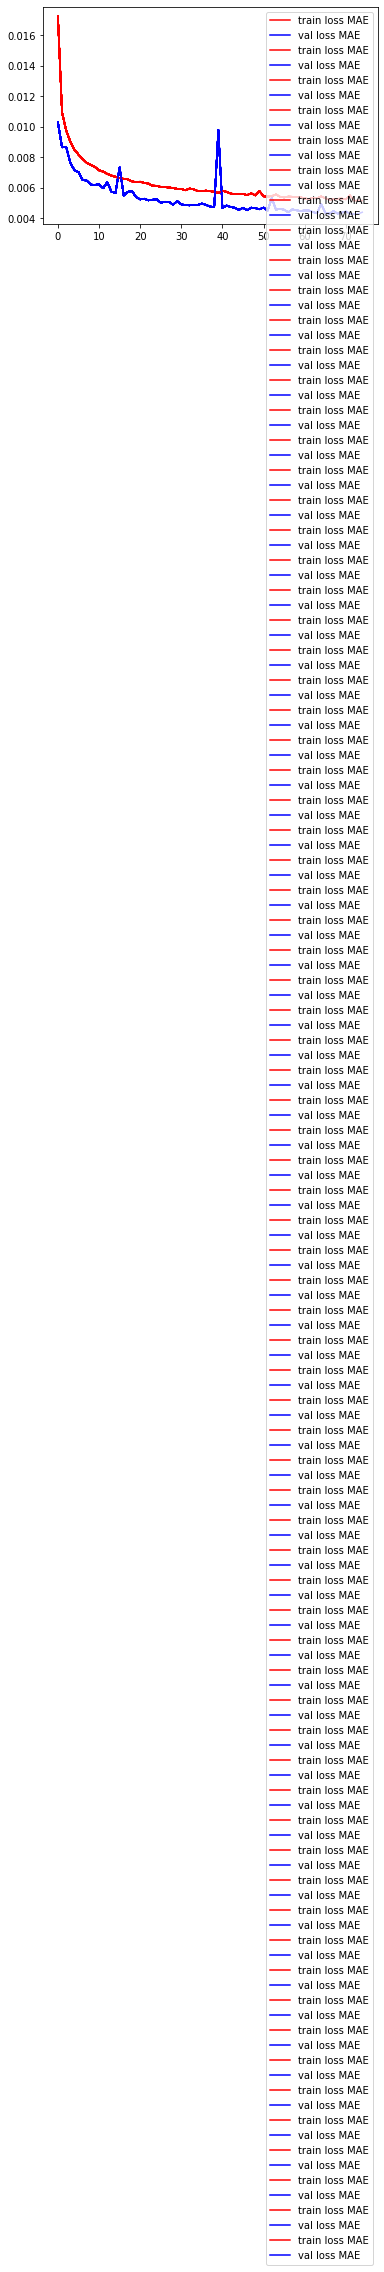

In [41]:
## create data generator, train model and save model.
BG = BatchGenerator()
MT = ModelTrainer()
MT.train_full_model()
print("finished training")
torch.save(MT.strongest_model, model_path + "model_t1_corrected")
model = torch.load(model_path + "model_t1_corrected")
model.eval()
print("saved the model")

from twilio.rest import Client
account_sid = "ACbb524ad1deed7bd1d53d2be7dd189de6"
auth_token = "9a0a01cddac5b0c827eb89a534fa897e"
client = Client(account_sid, auth_token)
FROM_NUM        = "+12562861398"
VERIFIED_NUMBER = "+447722355970"
message = client.messages.create(body='TESTING', from_=[FROM_NUM], to=[VERIFIED_NUMBER])
print(message.sid)

In [10]:
# test model on the full test sample:
BG = BatchGenerator()
model = torch.load(model_path + "model_t1")
model.eval()

criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()
BG = BatchGenerator()
train_full_loader, valid_full_loader, test_full_loader = BG.load_full_data()

test_lossesMAE_t1 = 0.0
test_lossesMAE_t5 = 0.0
test_lossesMAE_t10 = 0.0
test_lossesMAE_scaled = 0.0
test_lossesMAE_t15 = 0.0
test_lossesMAE_t20 = 0.0
test_lossesMAE_t25 = 0.0
test_lossesMAE_t35 = 0.0
test_lossesMAE_t40 = 0.0
test_lossesMAE_t48 = 0.0


test_lossesMAE_sheerx = 0.0
test_lossesMAE_sheery = 0.0
test_lossesMAE_normal = 0.0


tactile_gt_test = []
tactile_gt_d1_test = []
tactile_gt_d2_test = []
action_test = []

tactile_predictions = []
tactile_groundtruth = []
experiment_time_steps = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(test_full_loader):
        # 2. Reshape data and send to device:
        action = batch_features[0].squeeze(-1).permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)
        tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
        tactilederiv2 = batch_features[3].permute(1,0,2).to(device)
        tp = model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.
        experiment_time_steps.append([batch_features[-2], batch_features[-1]])
        tp = tp[:,:,:48]
        ############ RESCALE THE DATA HERE ################
        tp_back_scaled = []
        tg_back_scaled = []
        for i in range(len(tp)+1):
            if scale_together == False:
                if i is not 0:
                    # tp:
                    (tpx, tpy, tpz) = np.split(tp[i-1].cpu().detach(), 3, axis=1)
                    xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                    xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                    xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                    xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                    xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                    xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                    tp_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                         xela_y_inverse_full,
                                                         xela_z_inverse_full), axis=1))
                # tg:
                (tpx, tpy, tpz) = np.split(tactile[context_frames-1:][i].cpu().detach(), 3, axis=1)
                xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                tg_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                     xela_y_inverse_full,
                                                      xela_z_inverse_full), axis=1))
            else:
                tactile_prediction_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tp[i].cpu().detach())
                tp_back_scaled.append(scaler_full.inverse_transform(tactile_prediction_decoded))
                tactile_gt_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tactile[context_frames:][i].cpu().detach())
                tg_back_scaled.append(scaler_full.inverse_transform(tactile_gt_decoded))


        tp_back_scaled = torch.from_numpy(np.asarray(tp_back_scaled))
        tg_back_scaled = torch.from_numpy(np.asarray(tg_back_scaled))
        tactile_predictions.append(tp_back_scaled)
        tactile_groundtruth.append(tg_back_scaled)
        
        # for extended time step testing
        tactile_gt_test.append(tactile)
        tactile_gt_d1_test.append(tactilederiv1)
        tactile_gt_d2_test.append(tactilederiv2)
        action_test.append(action)

        # calculate losses for specific timesteps
        test_lossesMAE_scaled += criterion1(tp, tactile[context_frames:]).item()
        test_lossesMAE += criterion1(tp_back_scaled, tg_back_scaled[1:]).item()
        test_lossMAE_t1 = criterion1(tp_back_scaled[0,:,:], tg_back_scaled[1,:,:])
        test_lossesMAE_t1 += test_lossMAE_t1.item()
        test_lossMAE_t5 = criterion1(tp_back_scaled[4,:,:], tg_back_scaled[5,:,:])
        test_lossesMAE_t5 += test_lossMAE_t5.item()
        test_lossMAE_t10 = criterion1(tp_back_scaled[9,:,:], tg_back_scaled[10,:,:])
        test_lossesMAE_t10 += test_lossMAE_t10.item()
        test_lossMAE_sheerx = criterion1(tp_back_scaled[:,:,:16], tg_back_scaled[1:,:,:16])
        test_lossMAE_sheery = criterion1(tp_back_scaled[:,:,16:32], tg_back_scaled[1:,:,16:32])
        test_lossMAE_normal = criterion1(tp_back_scaled[:,:,32:], tg_back_scaled[1:,:,32:])
        test_lossesMAE_sheerx += test_lossMAE_sheerx.item() 
        test_lossesMAE_sheery += test_lossMAE_sheery.item() 
        test_lossesMAE_normal += test_lossMAE_normal.item() 
        
performance_data = []
performance_data.append(["unscaled test loss MAE(L1): ", (test_lossesMAE_scaled / index__)])
performance_data.append(["test loss MAE(L1): ", (test_lossesMAE / index__)])
performance_data.append(["test loss MAE(L1) timestep 1: ", (test_lossesMAE_t1 / index__)])
performance_data.append(["test loss MAE(L1) timestep 5: ", (test_lossesMAE_t5 / index__)])
performance_data.append(["test loss MAE(L1) timestep 10: ", (test_lossesMAE_t10 / index__)])
performance_data.append(["test loss MAE(L1) sheerx: ", (test_lossesMAE_sheerx / index__)])
performance_data.append(["test loss MAE(L1) sheery: ", (test_lossesMAE_sheery / index__)])
performance_data.append(["test loss MAE(L1) normal: ", (test_lossesMAE_normal / index__)])
[print(i) for i in performance_data]

np.save(model_path + 'performance_data10step_new_data', np.asarray(performance_data))

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

['unscaled test loss MAE(L1): ', 0.0074552963706082664]
['test loss MAE(L1): ', 80.99327177831141]
['test loss MAE(L1) timestep 1: ', 51.58502499679858]
['test loss MAE(L1) timestep 5: ', 77.50239046443356]
['test loss MAE(L1) timestep 10: ', 100.81672911131378]
['test loss MAE(L1) sheerx: ', 54.61483940466996]
['test loss MAE(L1) sheery: ', 53.766740410510295]
['test loss MAE(L1) normal: ', 134.598235519754]


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


In [11]:
print(p,len(p))
a = []
for i in index_to_test:
    a.append(i[0])
for index, i in enumerate(p):
    if i in a:
        print(index, i)

[204 160 153 234  91 137 176 243 274 238  13 175  30 127 197 102 205 151
 107  50 298  48  64 245 158 130 154 254  29 201  20 249 131 272 120 208
   3   5  90 212   0 209 206 145 198 143  54 118 172  59 213 210 267 188
 146  96  81 155 273 296 203 280 169 193 186 225  45 144  75  21  51 138
 141 117 294 236 229  37  61 112 284 231 194 261 214  80  39 171  53 180
 165  35  42 129 166  99 140  77 290  11  31 187 242 297  78 170 230 292
 207 215  76 163  10 253 181  56 122  83  86   8 148  72  70 126 285  26
 113 288 115  19 162 239  23 142  57 256 293   4  28 269 136 108 262 279
 228  60 240  71 149  89  40 232  44 103   2 133  65  85   7  41 123 211
  73  94 134  67 286 227  25 110 190 246  34  12 219 237 191 184  32 114
 222  33 250  36 174 266 264 202 271 182 189  24 109 157  87 247 105  17
   6 241  58 159 235 119 100 101 224 268 216 223 259 104 226  62 200  79
 295 220  43 255 282 196  55  93 289 185 192 263 178 217 139  69   9 111
 132 121 167 278 265 221 183 276 124 164  22  92  9

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180]


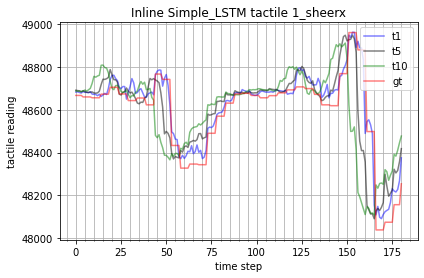

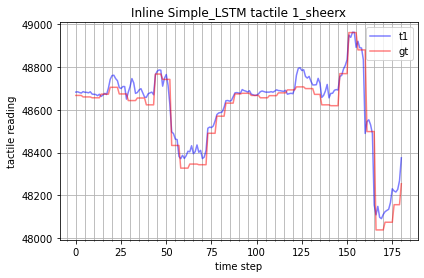

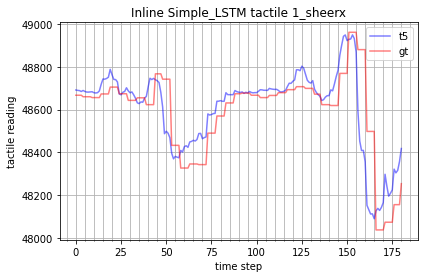

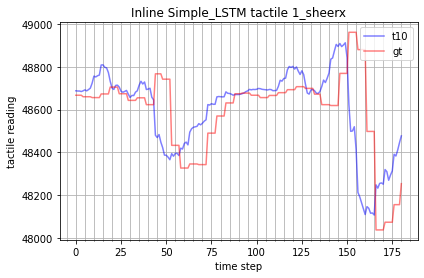

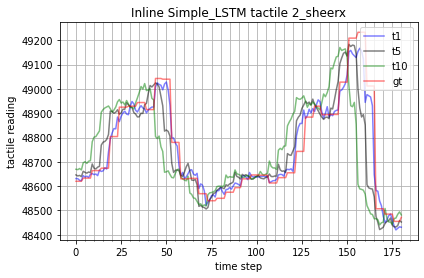

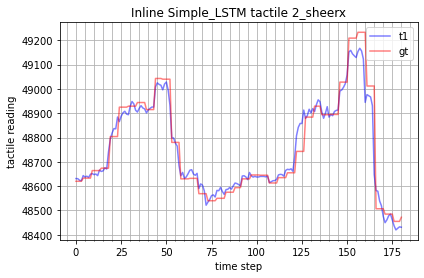

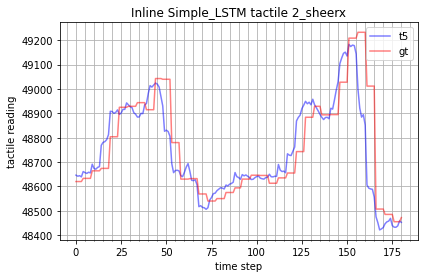

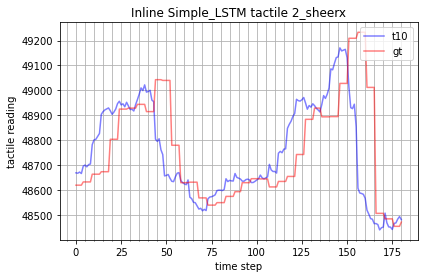

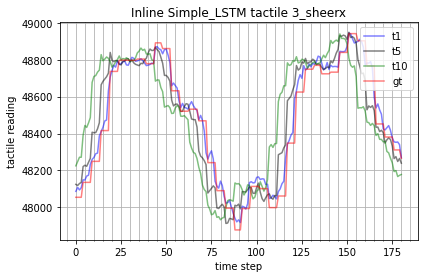

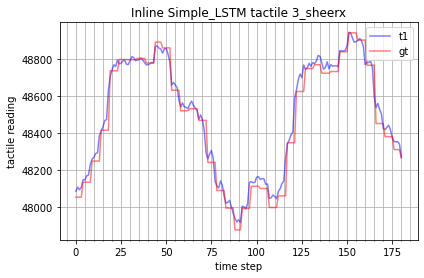

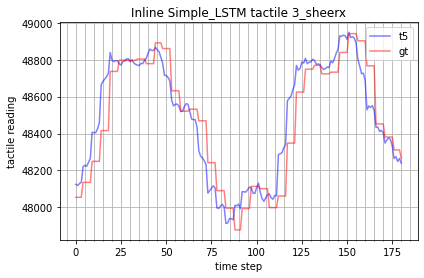

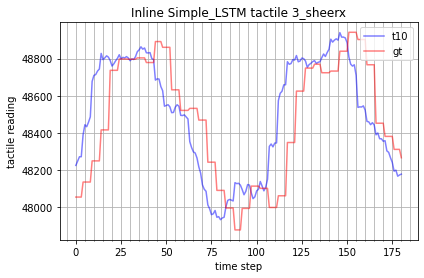

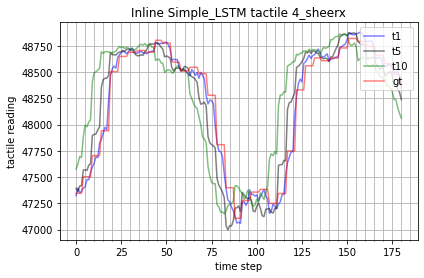

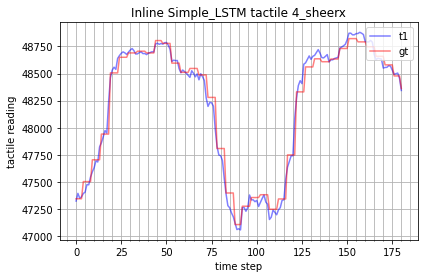

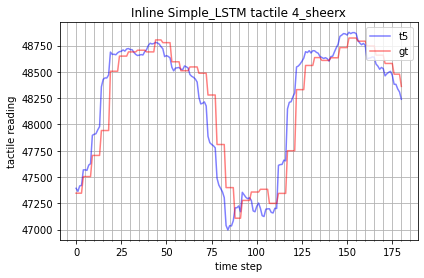

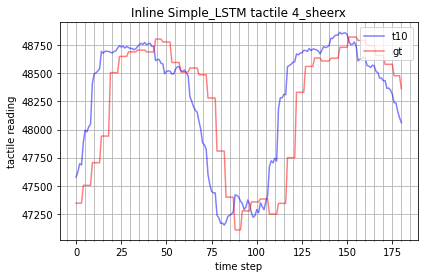

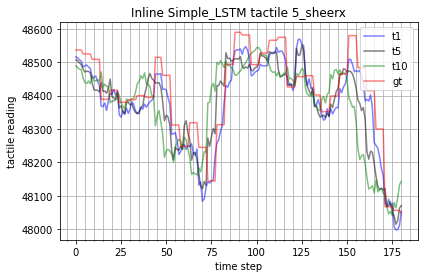

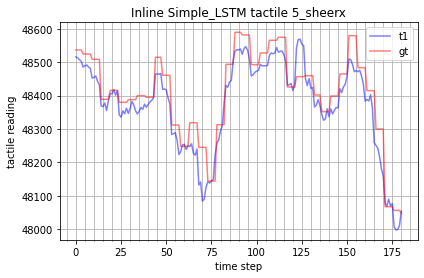

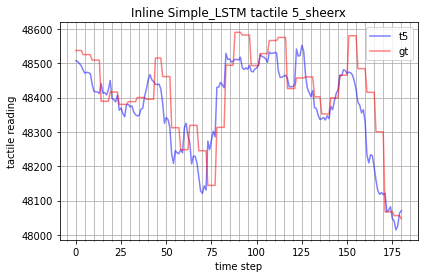

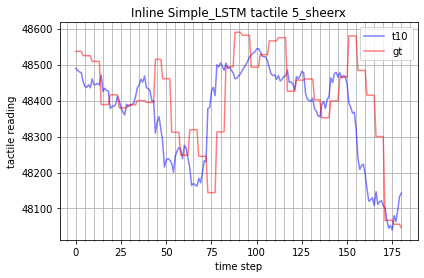

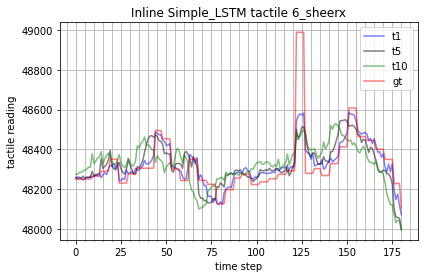

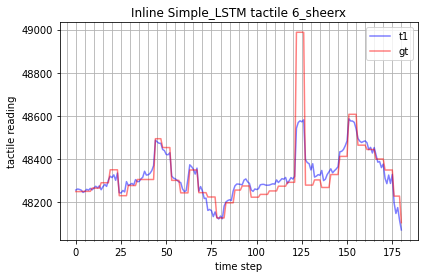

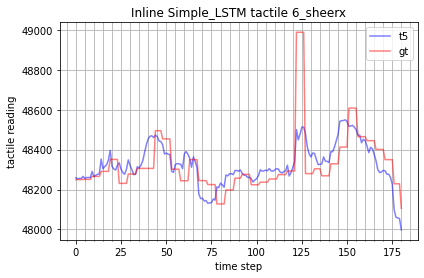

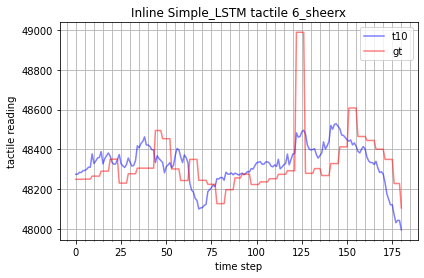

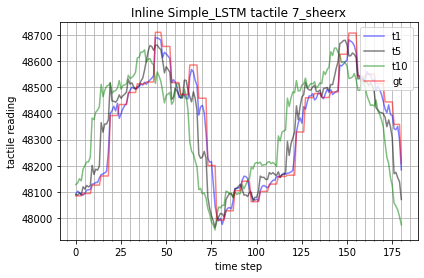

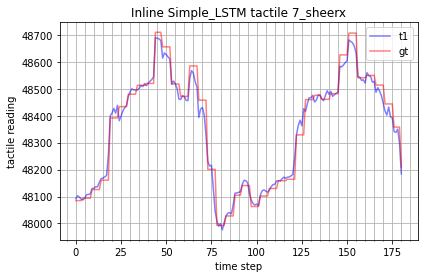

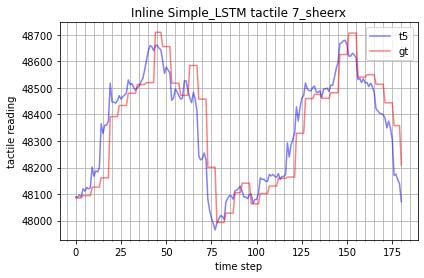

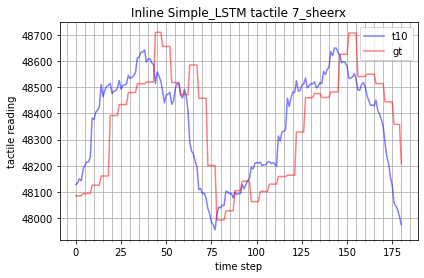

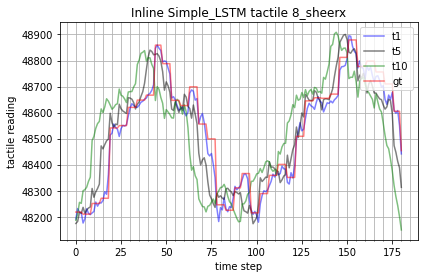

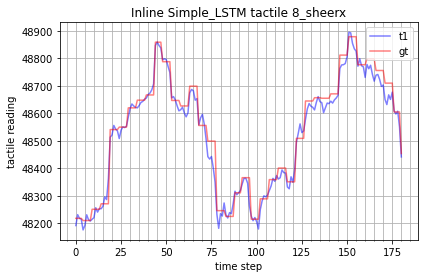

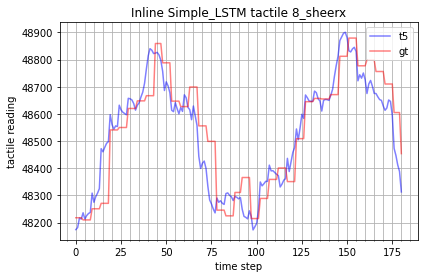

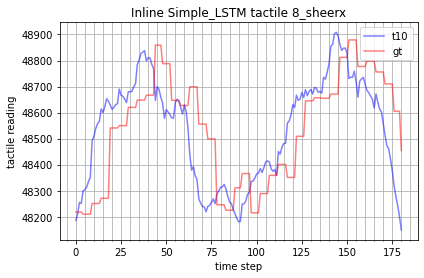

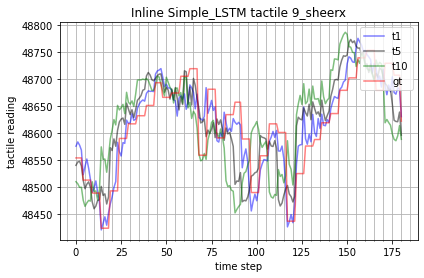

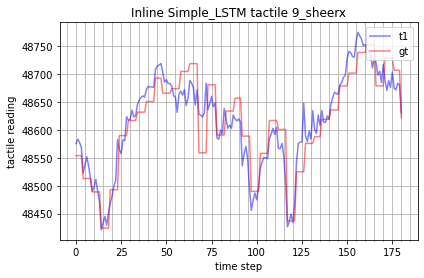

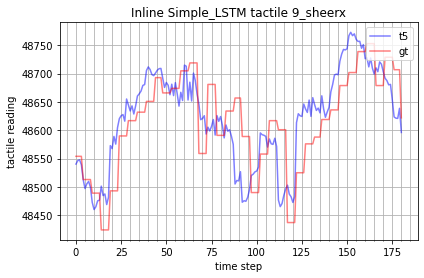

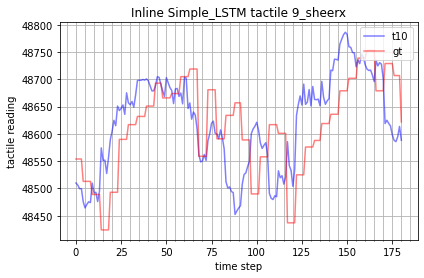

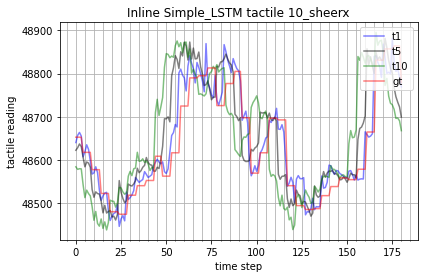

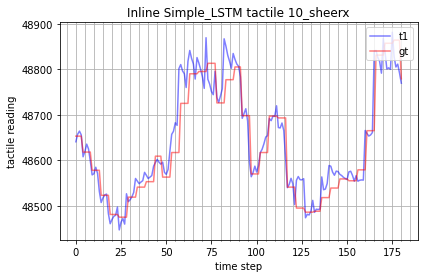

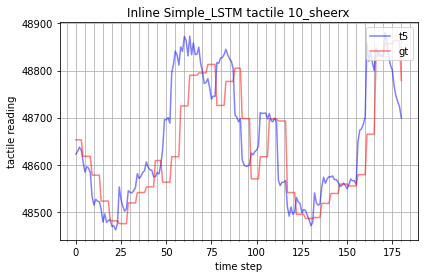

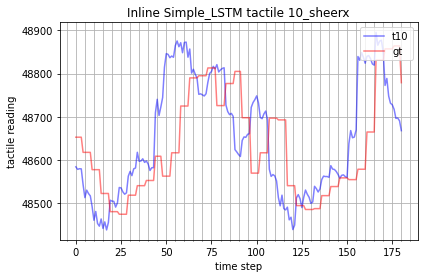

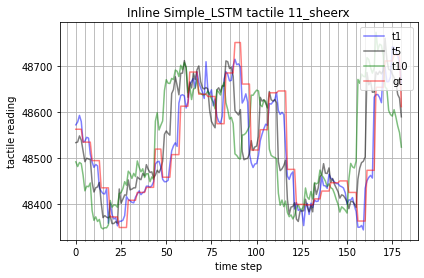

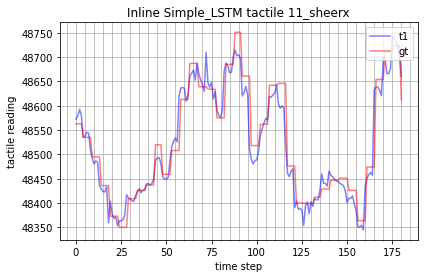

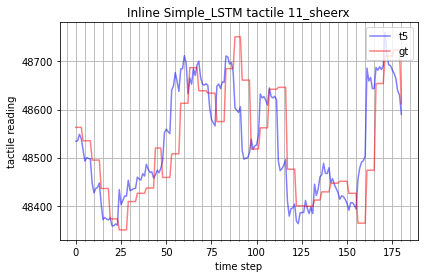

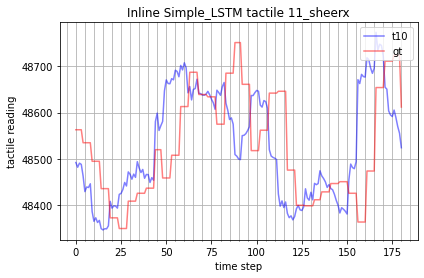

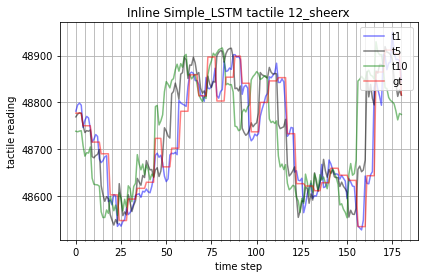

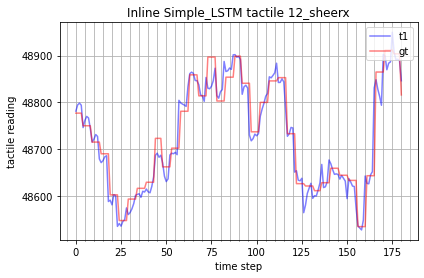

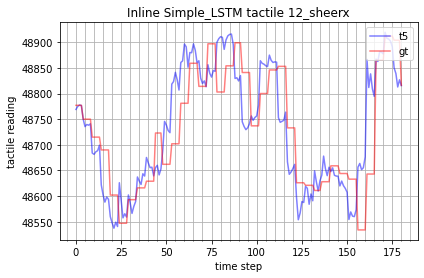

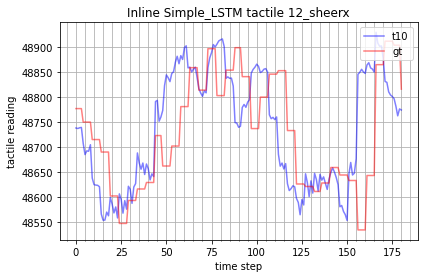

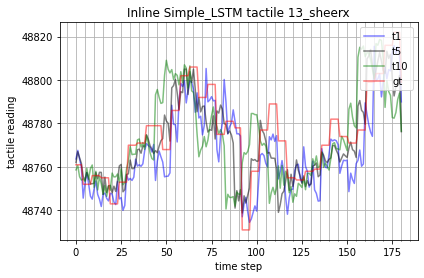

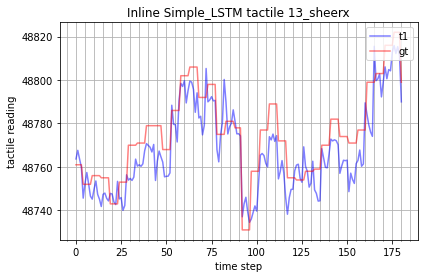

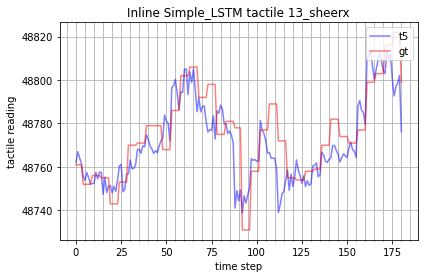

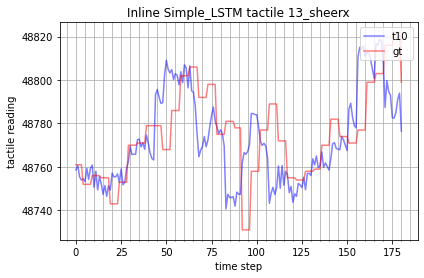

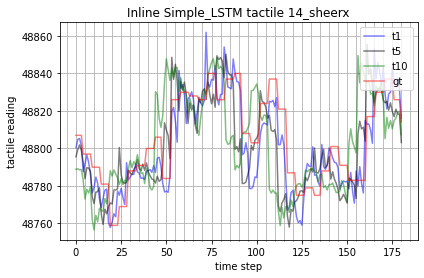

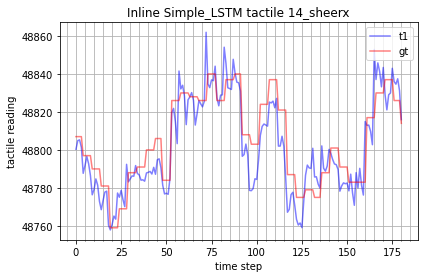

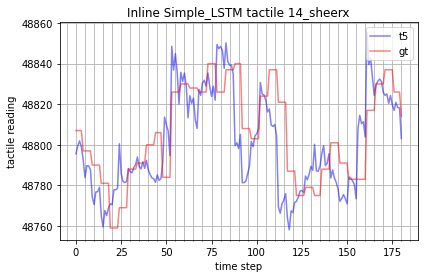

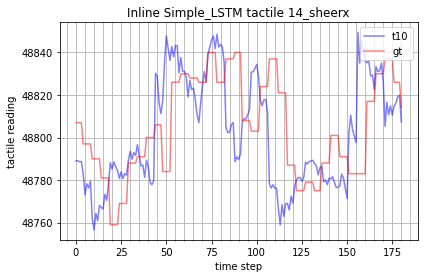

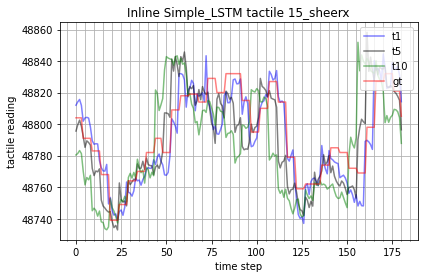

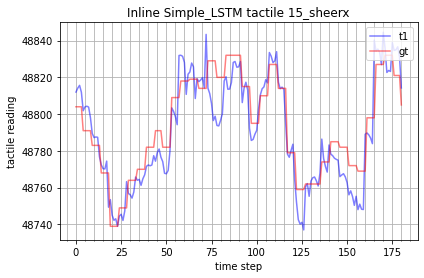

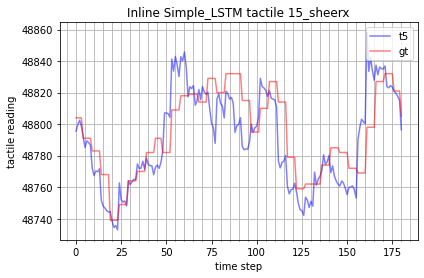

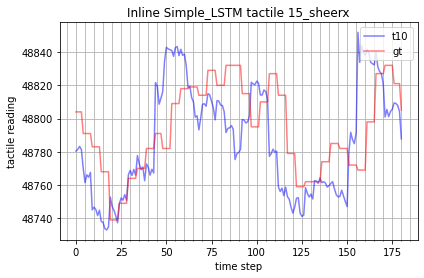

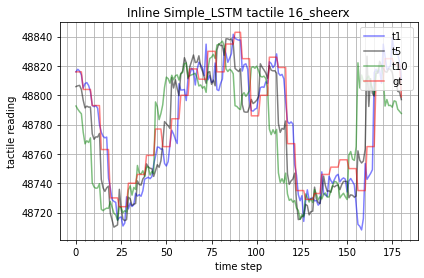

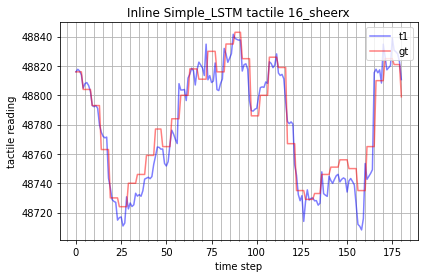

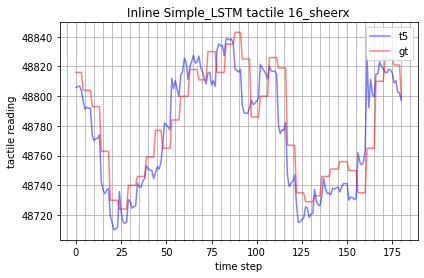

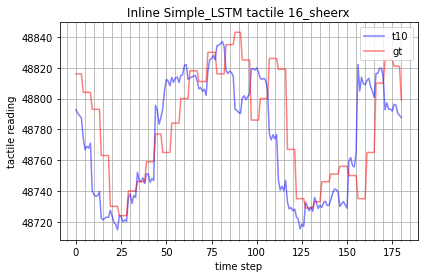

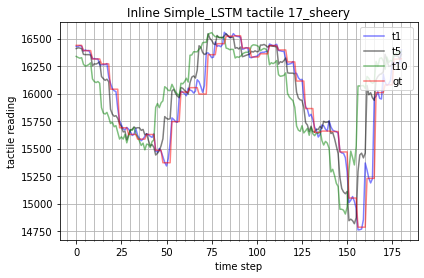

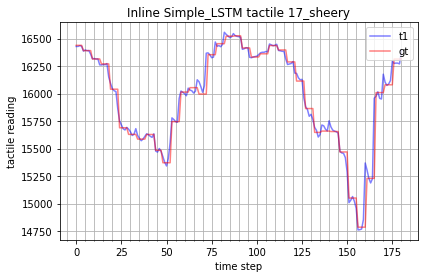

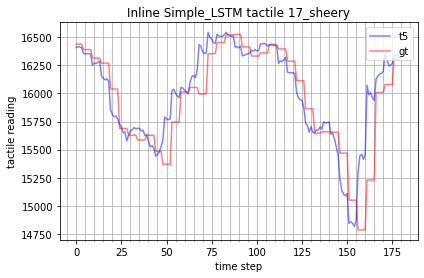

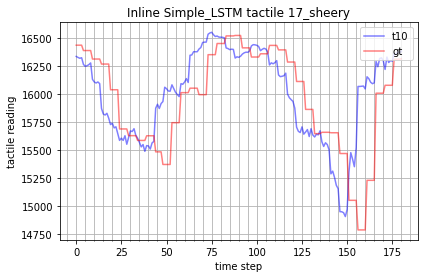

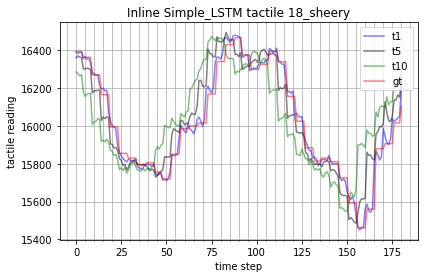

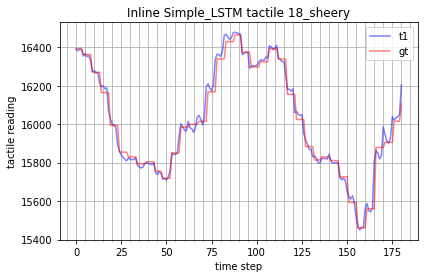

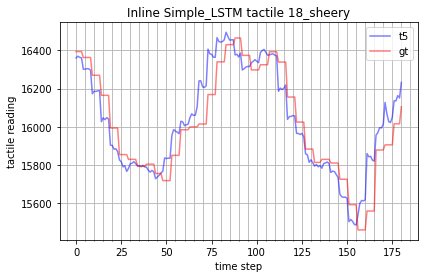

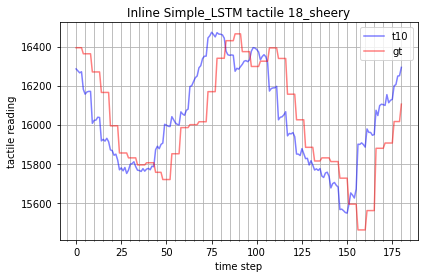

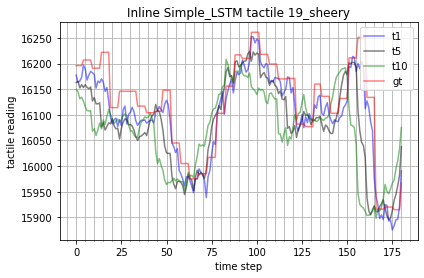

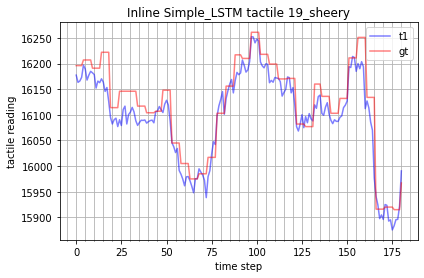

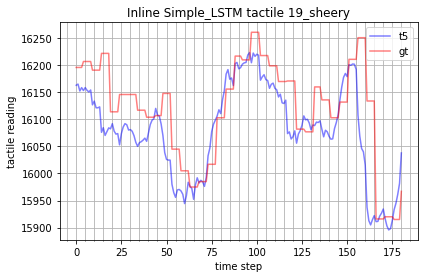

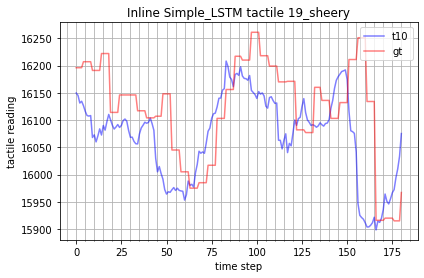

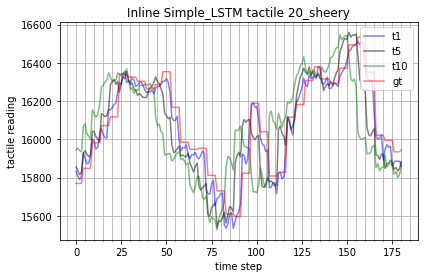

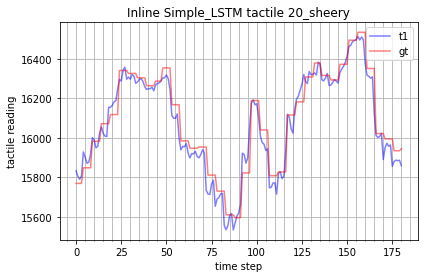

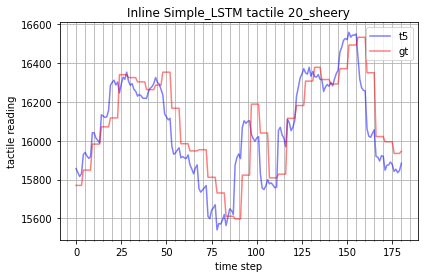

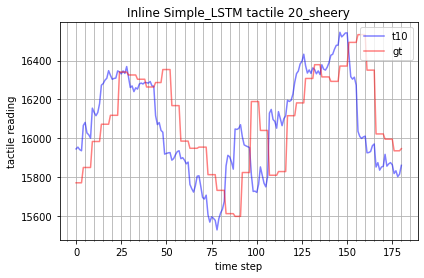

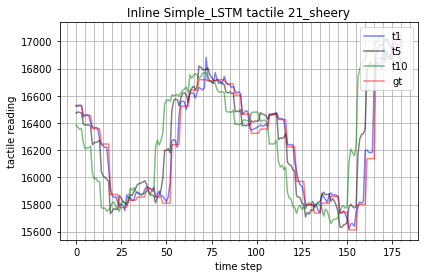

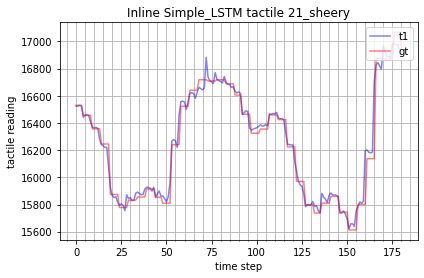

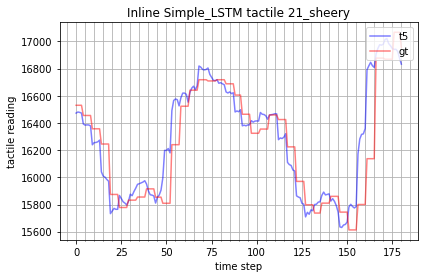

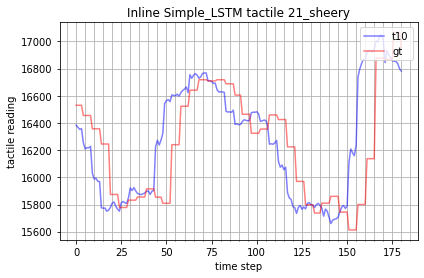

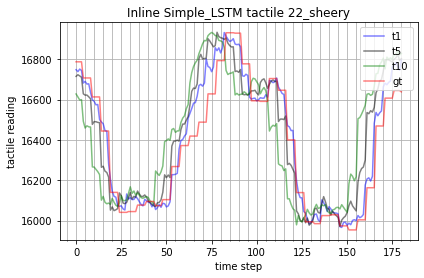

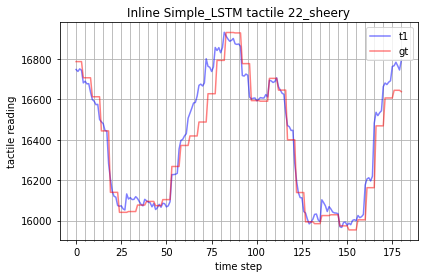

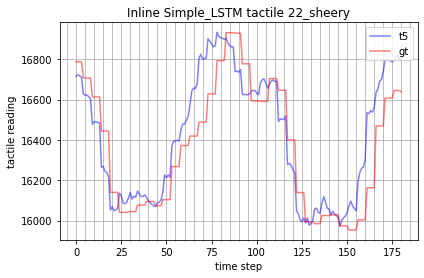

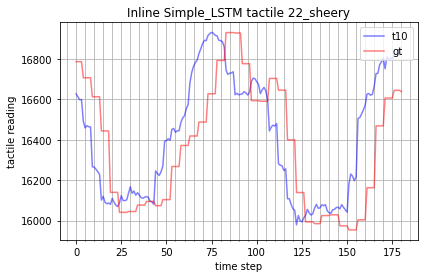

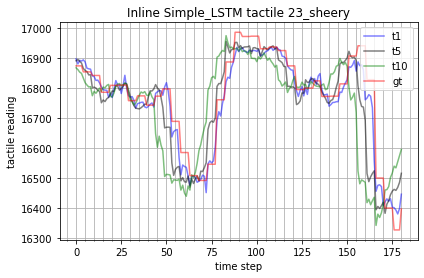

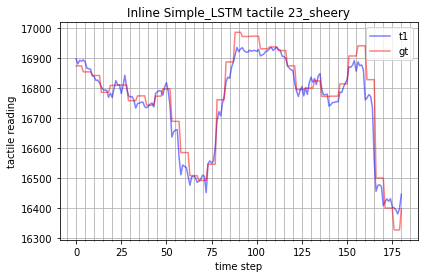

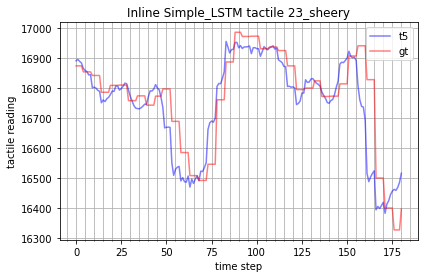

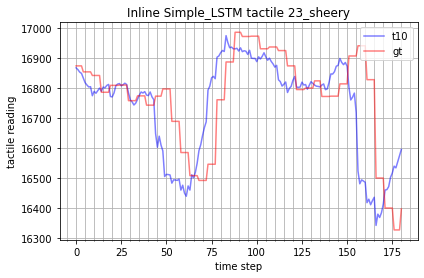

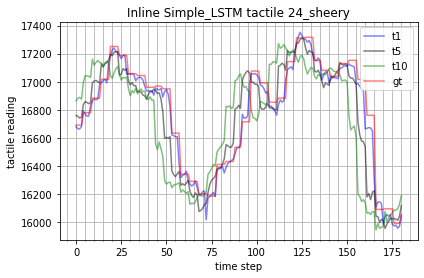

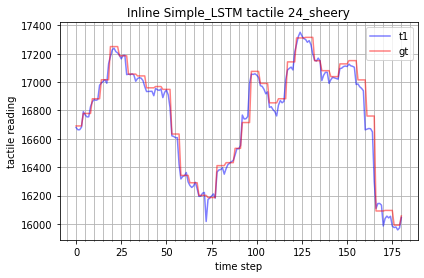

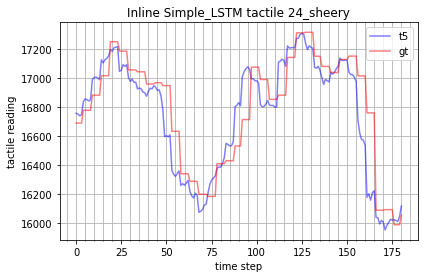

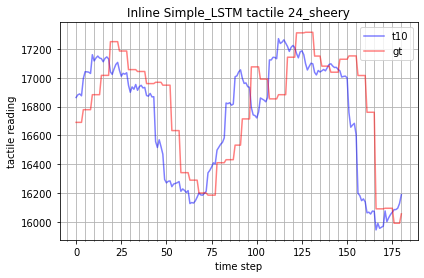

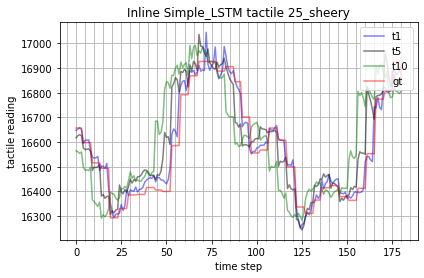

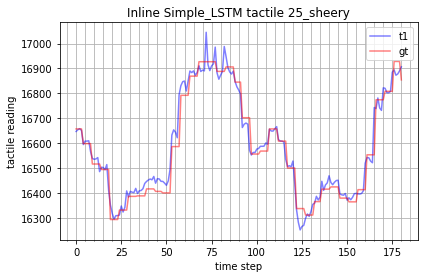

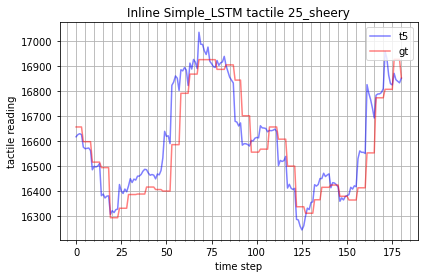

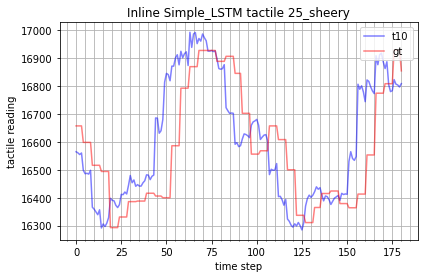

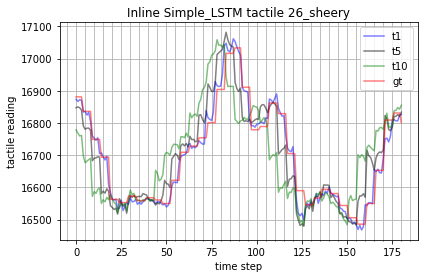

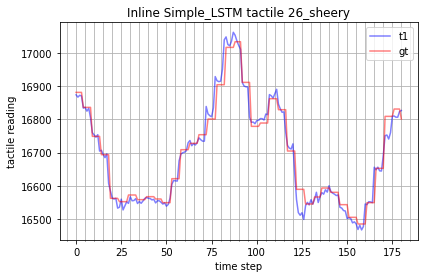

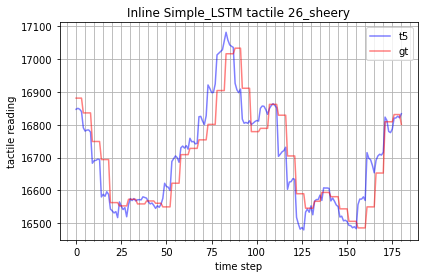

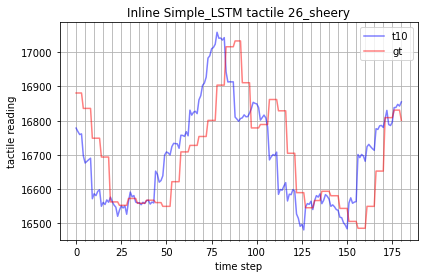

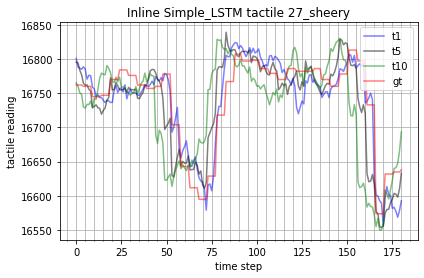

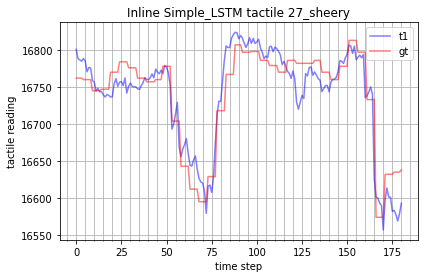

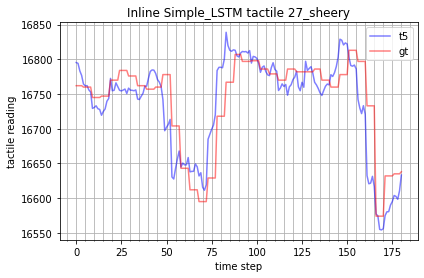

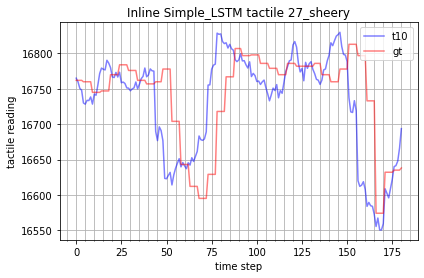

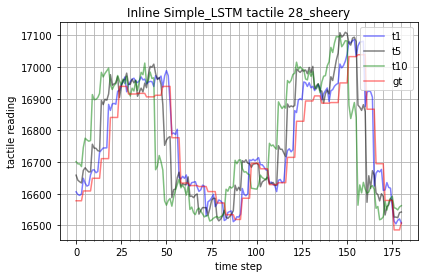

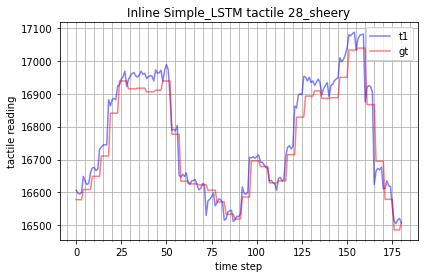

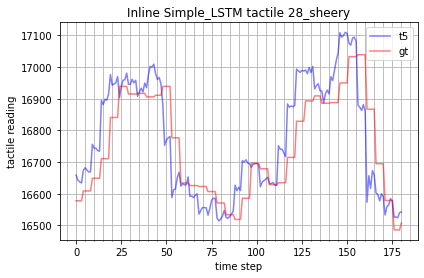

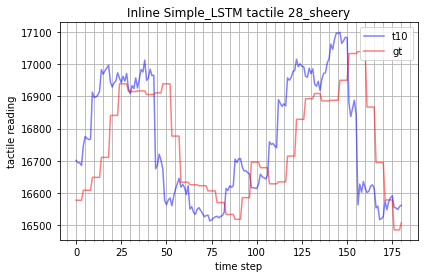

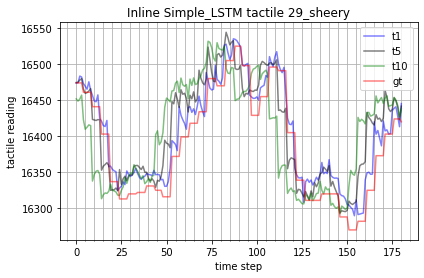

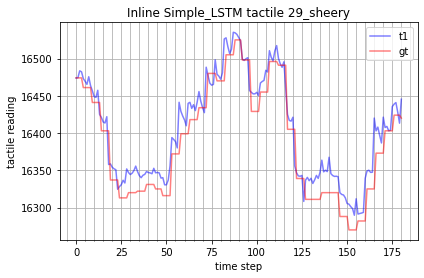

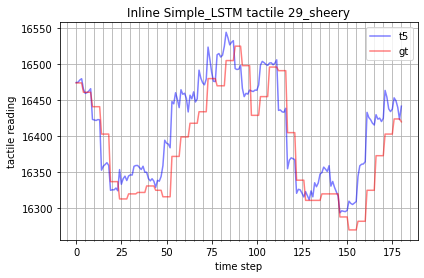

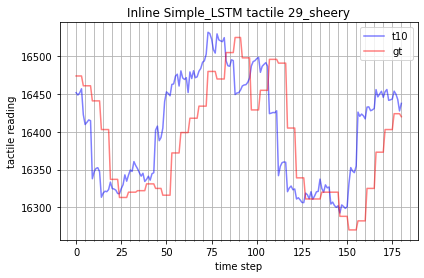

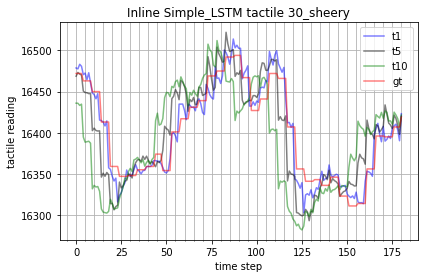

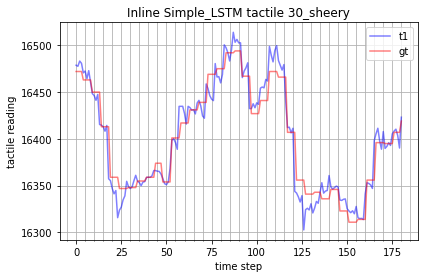

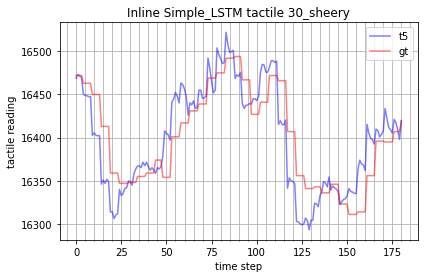

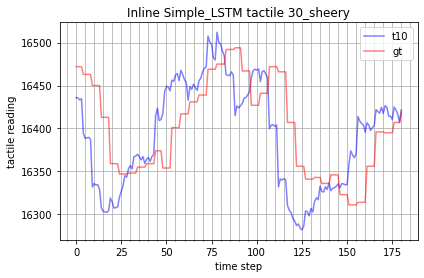

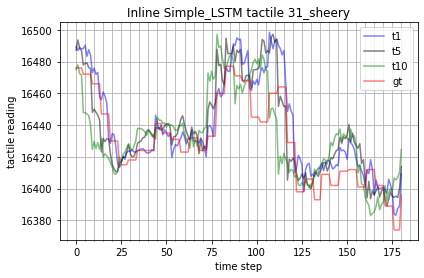

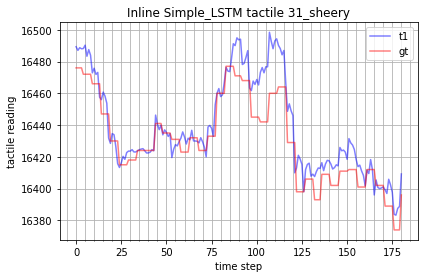

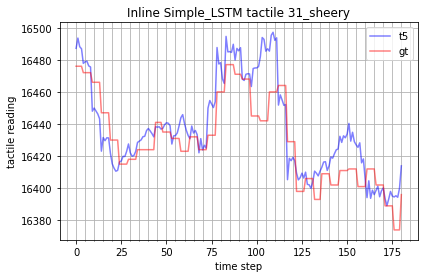

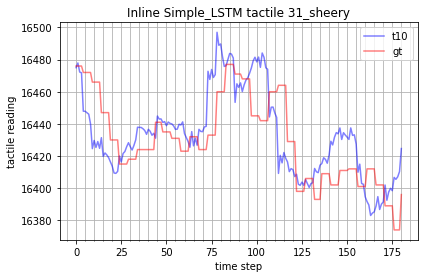

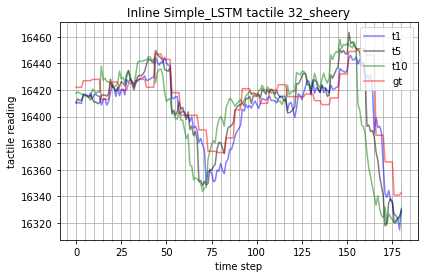

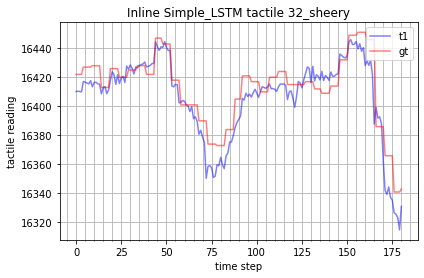

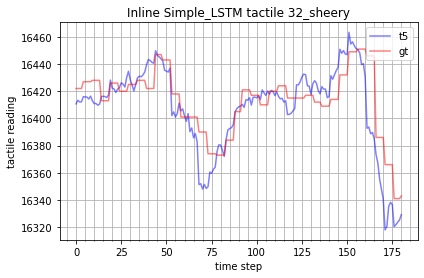

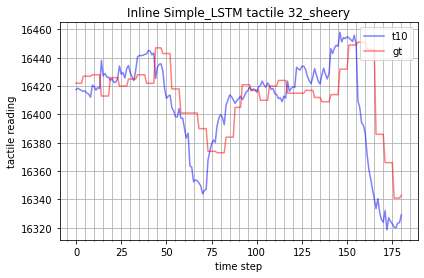

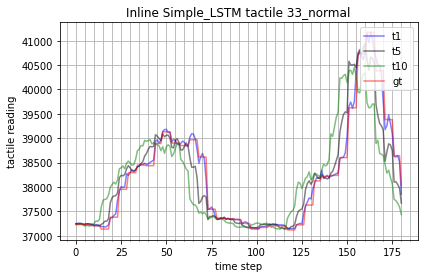

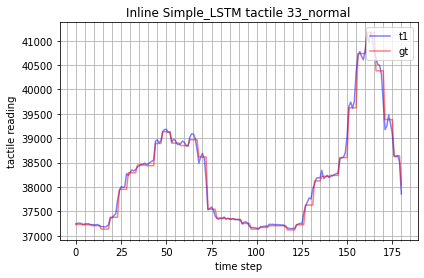

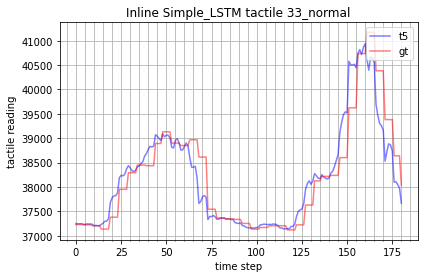

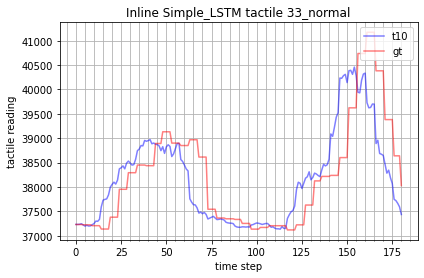

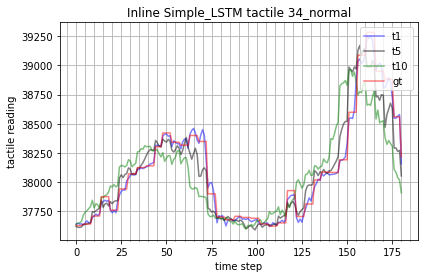

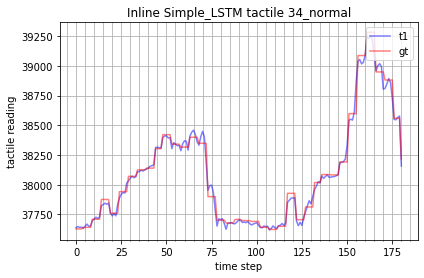

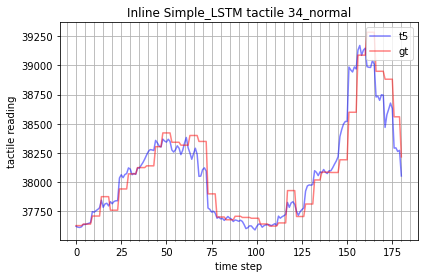

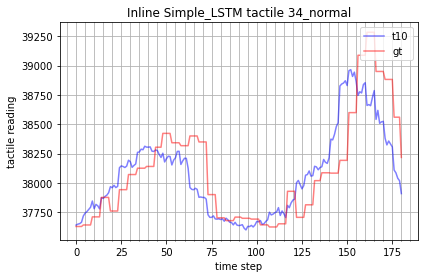

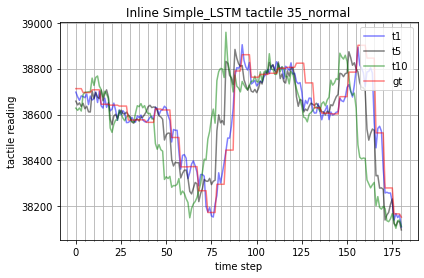

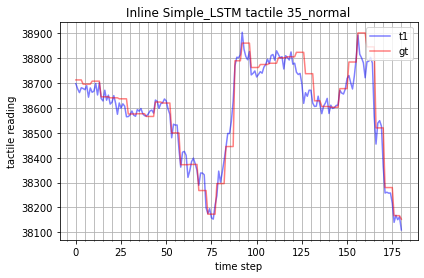

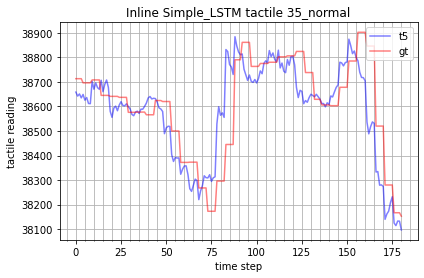

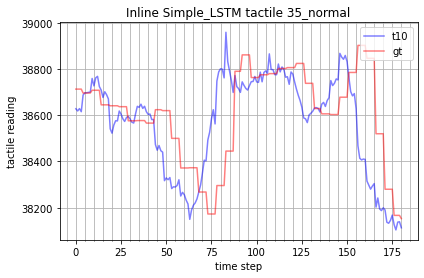

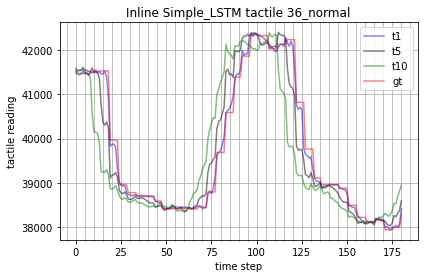

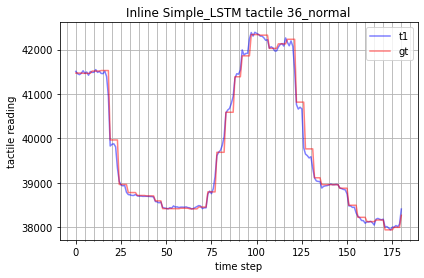

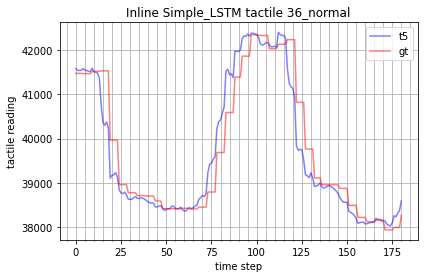

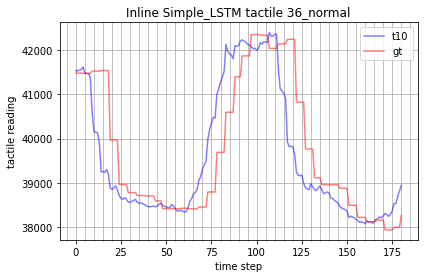

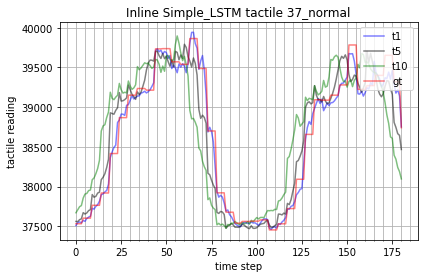

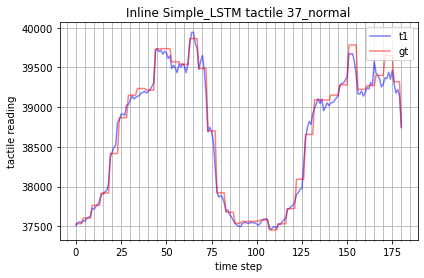

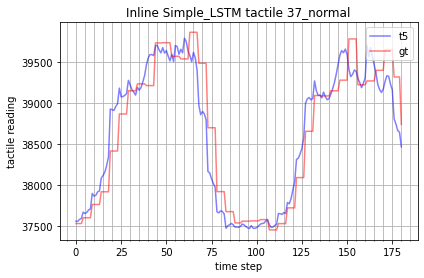

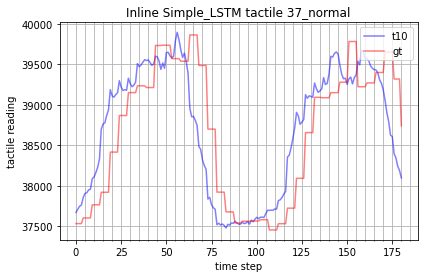

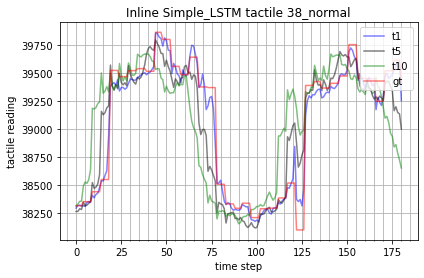

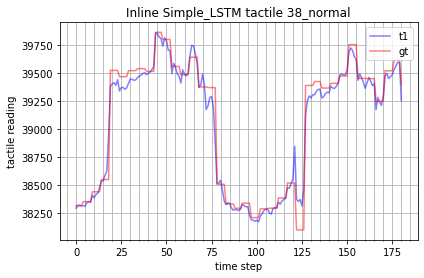

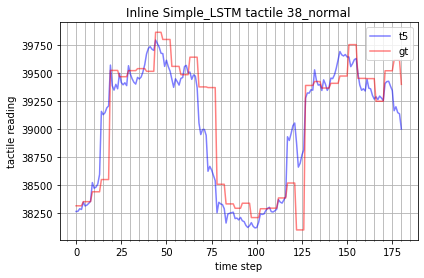

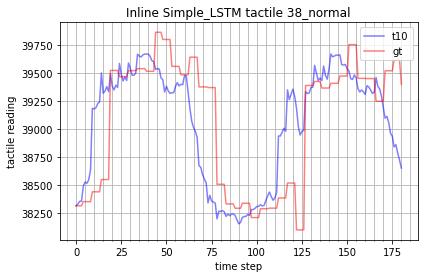

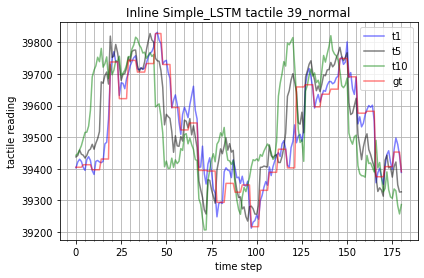

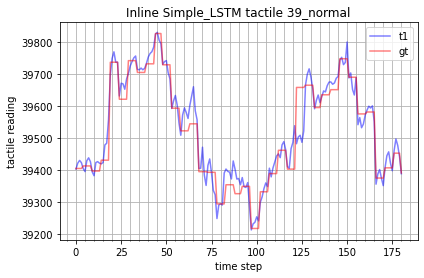

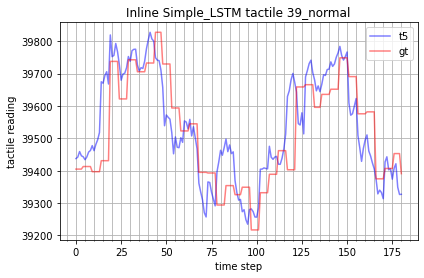

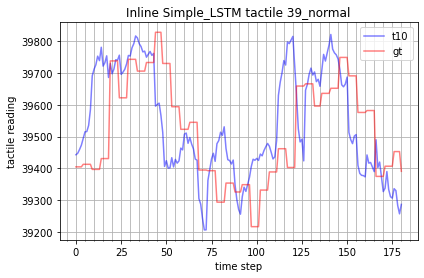

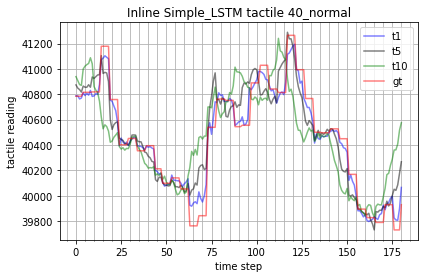

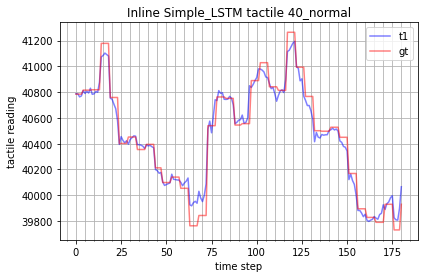

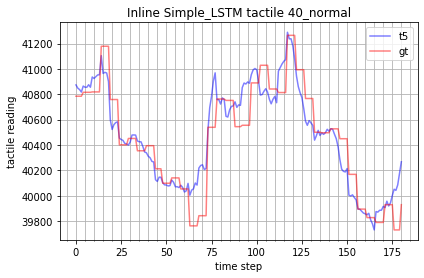

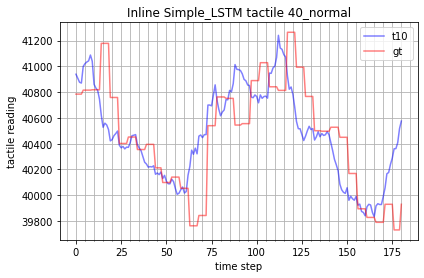

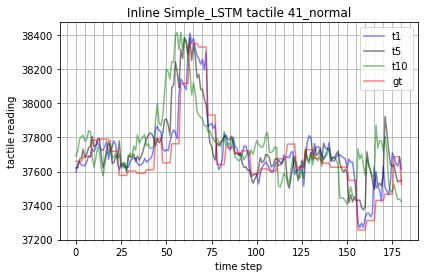

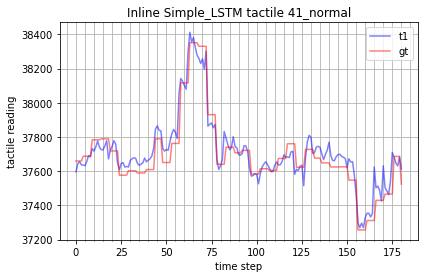

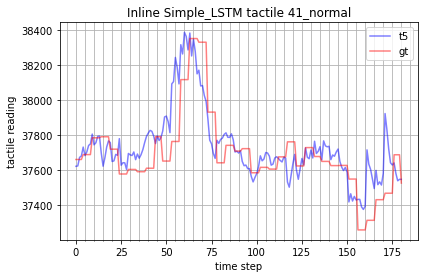

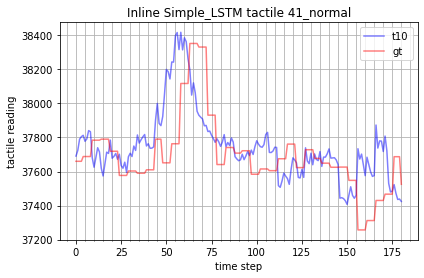

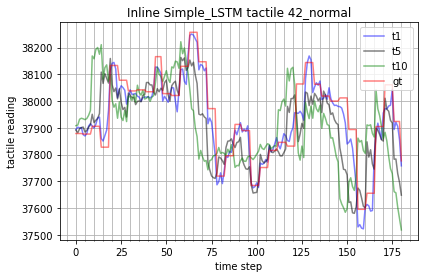

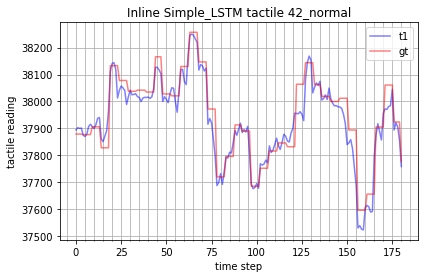

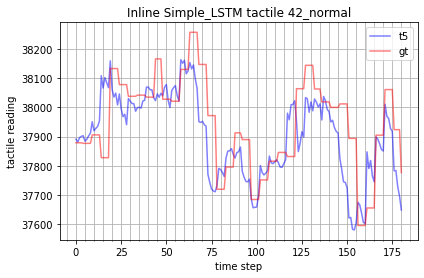

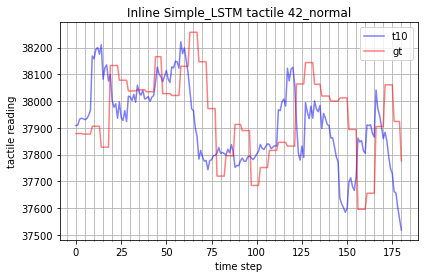

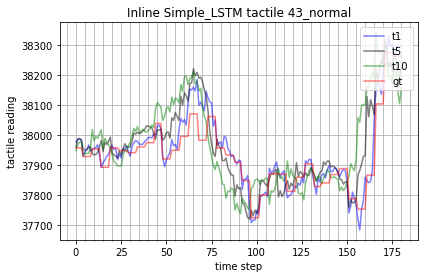

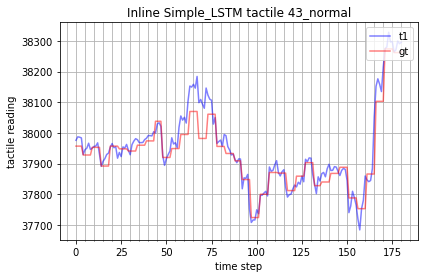

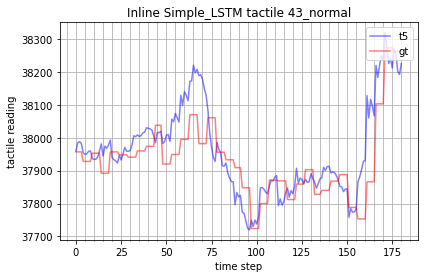

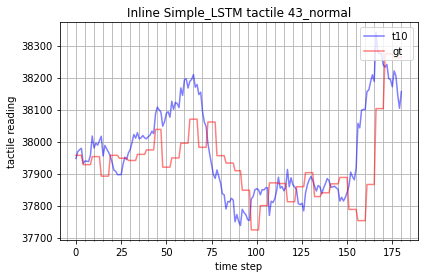

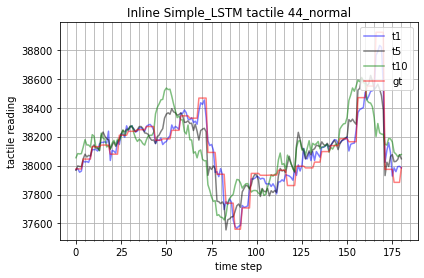

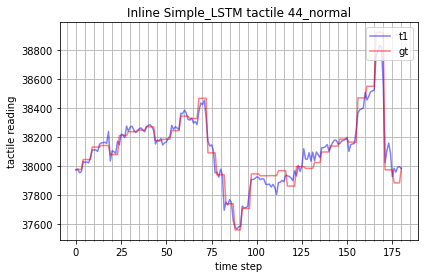

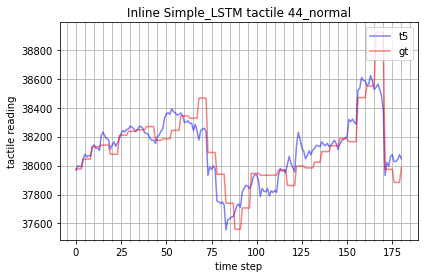

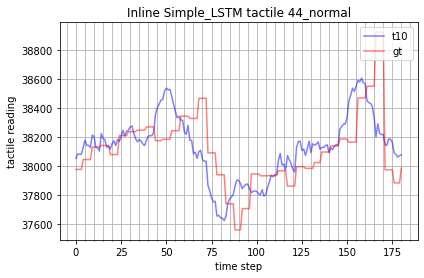

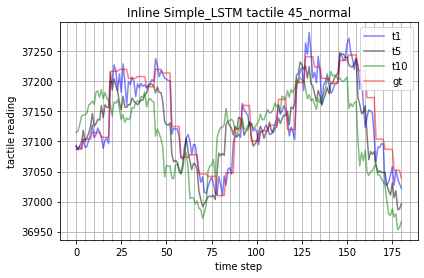

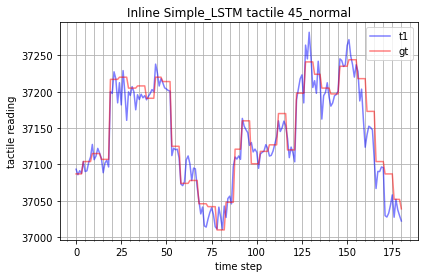

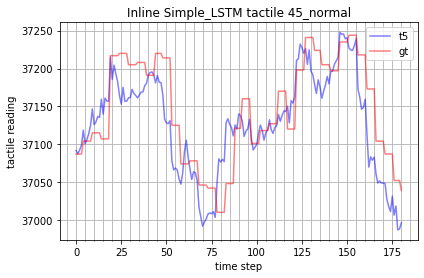

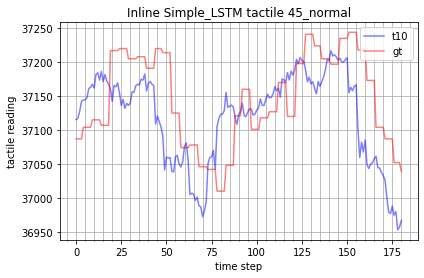

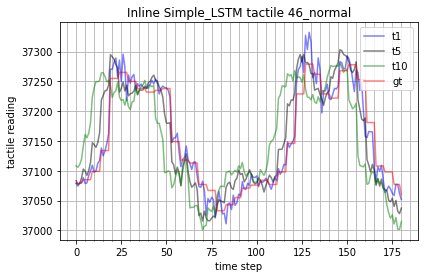

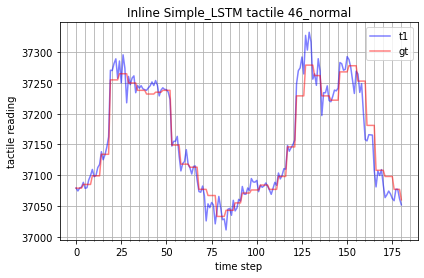

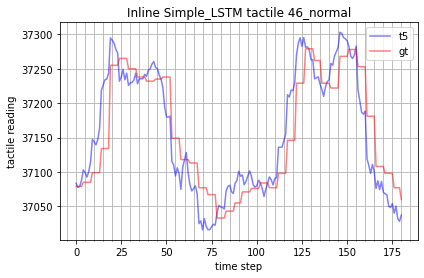

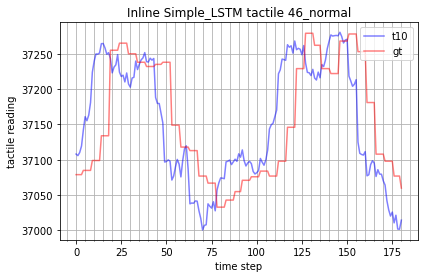

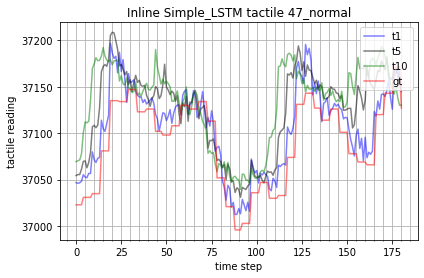

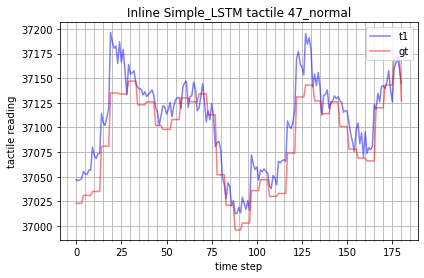

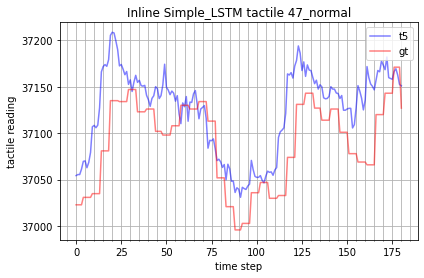

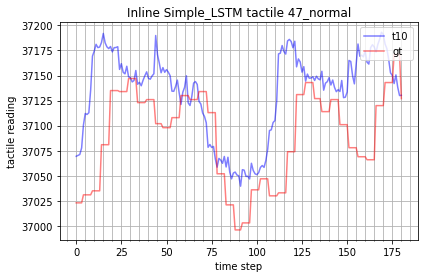

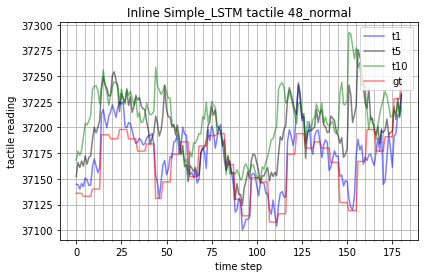

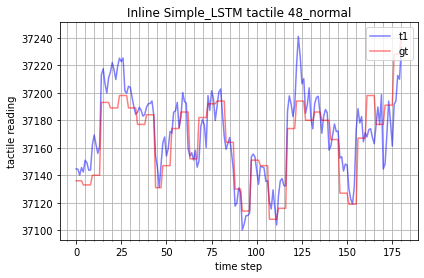

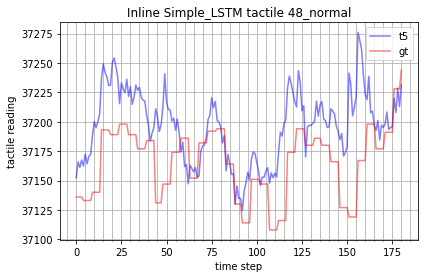

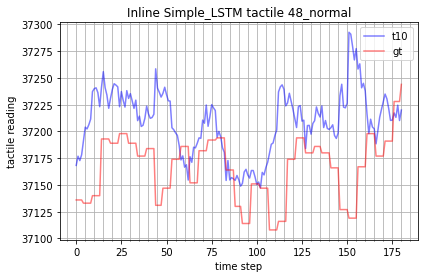

In [12]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
time_stepsto_plot = []
test_t = []
test_d1 = []
test_d2 = []
test_a = []
experiment_to_test = len(p) - 3  # experiment 106 as its the last one
for batchset in range(len(tactile_predictions)):
    for batch in range(len(tactile_predictions[batchset][time_step_to_test_t9])):
        experiment = experiment_time_steps[batchset][0][batch][0].numpy()
        time_step = experiment_time_steps[batchset][1][batch][0].numpy()
        if experiment == experiment_to_test:
            predicted_data_t1.append(tactile_predictions[batchset][time_step_to_test_t1][batch])
            predicted_data_t5.append(tactile_predictions[batchset][time_step_to_test_t5][batch])
            predicted_data_t9.append(tactile_predictions[batchset][time_step_to_test_t9][batch])
            groundtruth_data.append(tactile_groundtruth[batchset][0][batch])
            time_stepsto_plot.append(time_step.item())

print(time_stepsto_plot)
# test data
index = 0
plot_range_start = 0
plot_range_stop  = len(time_stepsto_plot) # len(time_stepsto_plot)
experiment_to_test = 199
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t5 = []
        predicted_taxel_t9 = []
        for k in range(plot_range_start, plot_range_stop):# len(predicted_data_t1)):#310, 325):#len(predicted_data_t1)):  # add in length of context data
            predicted_taxel_t1.append(predicted_data_t1[k][index].cpu().detach().numpy())
            predicted_taxel_t5.append(predicted_data_t5[k][index].cpu().detach().numpy())
            predicted_taxel_t9.append(predicted_data_t9[k][index].cpu().detach().numpy())
            groundtruth_taxle.append(groundtruth_data[k][index].cpu().detach().numpy())

        index += 1
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')        
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t1], alpha=0.5, c="b", label="t1")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t5], alpha=0.5, c="k", label="t5")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t9], alpha=0.5, c="g", label="t10")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path+ str(experiment_to_test) + '/10step_prediction_new_data/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_tactile_' + str(index) + '.png', dpi=300)
        plt.show()

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t1], alpha=0.5, c="b", label="t1")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.savefig(model_path + str(experiment_to_test) + '/10step_prediction_new_data/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T1_tactile_' + str(index) + '.png', dpi=300)
        plt.show()
        
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t5], alpha=0.5, c="b", label="t5")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + str(experiment_to_test) + '/10step_prediction_new_data/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T5_tactile_' + str(index) + '.png', dpi=300)
        plt.show()
            
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t9], alpha=0.5, c="b", label="t10")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + str(experiment_to_test) + '/10step_prediction_new_data/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T10_tactile_' + str(index) + '.png', dpi=300)
        plt.show()
    

In [ ]:
for batchset in range(len(tactile_predictions)):
    for batch in range(len(tactile_predictions[batchset][time_step_to_test_t9])):
        print(experiment_time_steps[batchset][0][batch][0].numpy(), experiment_time_steps[batchset][1][batch][0].numpy())